In [1]:
!pip install wandb
import wandb
!wandb login 58a0b576fd5221cd0d63b154deaabbe535e853c6

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [2]:
# =======================
# Imports and Sweep Config
# =======================
# =======================
# Imports and Sweep Config
# =======================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import wandb
import os
import math

sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'parameters': {
        'embedding_dim': {'values': [32,64,128,256]},
        'hidden_dim': {'values': [32,64,128,256]},
        'enc_layers': {'values': [1,2,3]},
        'dec_layers': {'values': [1,2,3]},
        'cell_type': {'values': ['GRU', 'LSTM', 'RNN']},
        'dropout': {'values': [0.2,0.3,0.5]},
        'epochs': {'values': [10,15]},
        'beam_size': {'values': [1,3,5]},
        'attention_type': {'values': ['dot', 'general', 'concat']},
        'batch_size': {'values': [64,128,256]},
        'learning_rate': {'values': [0.001,0.0005,0.0001]}
    }
}

# =======================
# Default Config
# =======================
default_config = {
    'embedding_dim': 32,
    'hidden_dim': 64,
    'enc_layers': 1,
    'dec_layers': 1,
    'cell_type': 'LSTM',
    'dropout': 0.2,
    'epochs': 10,
    'beam_size': 1,
    'attention_type': 'general',
    'batch_size': 64,
    'learning_rate': 0.001
}


# =======================
# Vocabulary
# =======================
class Vocab:
    def __init__(self):
        self.char2idx = {"<pad>": 0, "<sos>": 1, "<eos>": 2}
        self.idx2char = {0: "<pad>", 1: "<sos>", 2: "<eos>"}
        self.size = 3

    def build(self, texts):
        for text in texts:
            for char in text:
                if char not in self.char2idx:
                    self.char2idx[char] = self.size
                    self.idx2char[self.size] = char
                    self.size += 1

    def encode(self, text):
        return [self.char2idx[c] for c in text]

    def decode(self, idxs):
        return ''.join([self.idx2char[i] for i in idxs if i > 2])

# =======================
# Dataset
# =======================
class TransliterationDataset(Dataset):
    def __init__(self, filepath, inp_vocab, out_vocab):
        self.pairs = []
        with open(filepath, encoding='utf-8') as f:
            for line in f:
                fields = line.strip().split('\t')
                if len(fields) < 2:
                    continue
                lat, dev = fields[0], fields[1]
                self.pairs.append((lat, dev))
        inp_vocab.build([p[0] for p in self.pairs])
        out_vocab.build([p[1] for p in self.pairs])
        self.inp_vocab = inp_vocab
        self.out_vocab = out_vocab

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        lat, dev = self.pairs[idx]
        x = self.inp_vocab.encode(lat)
        y = [self.out_vocab.char2idx["<sos>"]] + self.out_vocab.encode(dev) + [self.out_vocab.char2idx["<eos>"]]
        return torch.tensor(x), torch.tensor(y)

def collate_fn(batch):
    x_batch, y_batch = zip(*batch)
    x_lens = [len(x) for x in x_batch]
    y_lens = [len(y) for y in y_batch]
    x_pad = nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value=0)
    y_pad = nn.utils.rnn.pad_sequence(y_batch, batch_first=True, padding_value=0)
    return x_pad, y_pad, torch.tensor(x_lens), torch.tensor(y_lens)

# =======================
# Attention Mechanism
# =======================
class Attention(nn.Module):
    def __init__(self, hidden_dim, attention_type='general'):
        super().__init__()
        self.attention_type = attention_type
        
        if attention_type == 'general':
            self.attn = nn.Linear(hidden_dim, hidden_dim)
        elif attention_type == 'concat':
            self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
            self.v = nn.Linear(hidden_dim, 1, bias=False)
            
    def forward(self, hidden, encoder_outputs, mask=None):
        # hidden: [batch_size, hidden_dim]
        # encoder_outputs: [batch_size, src_len, hidden_dim]
        
        batch_size, src_len, hidden_dim = encoder_outputs.shape
        
        # For dot and general attention
        if self.attention_type == 'dot':
            # Calculate dot product between hidden and encoder_outputs
            energy = torch.bmm(encoder_outputs, hidden.unsqueeze(2)).squeeze(2)
            # energy: [batch_size, src_len]
            
        elif self.attention_type == 'general':
            # Calculate general attention
            energy = torch.bmm(encoder_outputs, self.attn(hidden).unsqueeze(2)).squeeze(2)
            # energy: [batch_size, src_len]
            
        elif self.attention_type == 'concat':
            # Repeat hidden across source length
            hidden_expanded = hidden.unsqueeze(1).repeat(1, src_len, 1)
            # Concatenate hidden and encoder_outputs
            energy = self.v(torch.tanh(self.attn(torch.cat((hidden_expanded, encoder_outputs), dim=2)))).squeeze(2)
            # energy: [batch_size, src_len]
        
        # Apply mask if provided (for padding)
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        # Apply softmax to get attention weights
        attention_weights = F.softmax(energy, dim=1)
        # attention_weights: [batch_size, src_len]
        
        # Apply attention weights to encoder outputs
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        # context: [batch_size, hidden_dim]
        
        return context, attention_weights

# =======================
# Encoder and Decoder
# =======================
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, cell_type, dropout):
        super().__init__()
        self.cell_type = cell_type
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        rnn_class = {"GRU": nn.GRU, "LSTM": nn.LSTM, "RNN": nn.RNN}[cell_type]
        self.rnn = rnn_class(emb_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False, dropout=dropout if num_layers > 1 else 0)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        outputs, hidden = self.rnn(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        
        return outputs, hidden

class AttentionDecoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, cell_type, dropout, attention_type):
        super().__init__()
        self.cell_type = cell_type
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        rnn_class = {"GRU": nn.GRU, "LSTM": nn.LSTM, "RNN": nn.RNN}[cell_type]
        
        # Input to RNN will be embedding + context vector
        self.rnn = rnn_class(emb_dim + hidden_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        self.attention = Attention(hidden_dim, attention_type)
        
        # Output layer combines hidden state and context vector
        self.out = nn.Linear(hidden_dim * 2, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_token, hidden, encoder_outputs, mask=None):
        # input_token: [batch_size]
        # hidden: tuple of [num_layers, batch_size, hidden_dim] for LSTM or [num_layers, batch_size, hidden_dim] for GRU/RNN
        # encoder_outputs: [batch_size, src_len, hidden_dim]
        
        # Get the last layer's hidden state for attention
        if self.cell_type == "LSTM":
            attn_hidden = hidden[0][-1]  # Last layer's hidden state
        else:
            attn_hidden = hidden[-1]  # Last layer's hidden state
        
        # Calculate attention
        context, attention_weights = self.attention(attn_hidden, encoder_outputs, mask)
        
        # Embed input token
        embedded = self.embedding(input_token)  # [batch_size, emb_dim]
        
        # Concatenate embedding and context vector
        rnn_input = torch.cat((embedded, context), dim=1).unsqueeze(1)  # [batch_size, 1, emb_dim + hidden_dim]
        
        # Pass through RNN
        output, hidden = self.rnn(rnn_input, hidden)
        
        # Get the output from the last layer
        if self.cell_type == "LSTM":
            output_hidden = hidden[0][-1]  # Last layer's hidden state
        else:
            output_hidden = hidden[-1]  # Last layer's hidden state
        
        # Concatenate output and context for prediction
        output = torch.cat((output_hidden, context), dim=1)
        
        # Apply dropout and predict
        output = self.dropout(output)
        prediction = self.out(output)
        
        return prediction, hidden, attention_weights

# =======================
# Seq2Seq Model with Beam Search
# =======================
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, enc_layers, dec_layers, cell_type, device, beam_size=1):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.cell_type = cell_type
        self.enc_layers = enc_layers
        self.dec_layers = dec_layers
        self.device = device
        self.beam_size = beam_size

    def create_mask(self, src, src_lens):
        # Create mask for attention (1 for valid positions, 0 for padding)
        batch_size = src.size(0)
        max_len = src.size(1)
        mask = torch.zeros(batch_size, max_len, device=self.device)
        for i, length in enumerate(src_lens):
            mask[i, :length] = 1
        return mask

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        src_data, src_lens = src
        batch_size, trg_len = trg.size()
        vocab_size = self.decoder.out.out_features
        
        # Store outputs, attention weights
        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)
        attentions = torch.zeros(batch_size, trg_len, src_data.size(1)).to(self.device)
        
        # Encode
        encoder_outputs, enc_hidden = self.encoder(src_data, src_lens)
        
        # Create mask for attention
        mask = self.create_mask(src_data, src_lens)
        
        # Match encoder and decoder layers
        if self.cell_type == "LSTM":
            h, c = enc_hidden
            h = self._match_layers(h)
            c = self._match_layers(c)
            dec_hidden = (h, c)
        else:
            dec_hidden = self._match_layers(enc_hidden)
        
        # First input to the decoder is the <sos> token
        input_token = trg[:, 0]
        
        for t in range(1, trg_len):
            output, dec_hidden, attn_weights = self.decoder(
                input_token, dec_hidden, encoder_outputs, mask
            )
            
            outputs[:, t] = output
            attentions[:, t] = attn_weights
            
            # Teacher forcing
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_token = trg[:, t] if teacher_force else top1
            
        return outputs, attentions

    def _match_layers(self, hidden):
        # Match encoder and decoder layers
        if self.enc_layers == self.dec_layers:
            return hidden
        elif self.enc_layers > self.dec_layers:
            return hidden[:self.dec_layers]
        else:
            pad = hidden.new_zeros((self.dec_layers - self.enc_layers, *hidden.shape[1:]))
            return torch.cat([hidden, pad], dim=0)
    
    def beam_search(self, src, max_len=50, sos_idx=1, eos_idx=2):
        src_data, src_lens = src
        batch_size = src_data.size(0)
        assert batch_size == 1, "Beam search only supports batch size of 1 for now"

        # Encode
        encoder_outputs, enc_hidden = self.encoder(src_data, src_lens)
        mask = self.create_mask(src_data, src_lens)

        # Prepare initial hidden state
        if self.cell_type == "LSTM":
            h, c = enc_hidden
            h = self._match_layers(h)
            c = self._match_layers(c)
            dec_hidden = (h, c)
        else:
            dec_hidden = self._match_layers(enc_hidden)

        # Initialize beams with [score, sequence, hidden_state]
        beams = [{
            "score": 0.0,
            "seq": [sos_idx],
            "hidden": dec_hidden
        }]

        for _ in range(max_len):
            new_beams = []
            for beam in beams:
                seq = beam["seq"]
                if seq[-1] == eos_idx:
                    new_beams.append(beam)
                    continue

                input_token = torch.tensor([seq[-1]], device=self.device)
                dec_hidden = beam["hidden"]
                output, new_hidden, _ = self.decoder(input_token, dec_hidden, encoder_outputs, mask)

                log_probs = F.log_softmax(output, dim=1).squeeze(0)
                topk_log_probs, topk_indices = torch.topk(log_probs, self.beam_size)

                for log_prob, idx in zip(topk_log_probs, topk_indices):
                    new_beams.append({
                        "score": beam["score"] + log_prob.item(),
                        "seq": beam["seq"] + [idx.item()],
                        "hidden": new_hidden
                    })

            # Keep top `beam_size` beams
            beams = sorted(new_beams, key=lambda x: x["score"], reverse=True)[:self.beam_size]

            # Early stopping if all beams end with <eos>
            if all(beam["seq"][-1] == eos_idx for beam in beams):
                break

        # Choose best beam
        best_beam = max(beams, key=lambda x: x["score"])
        return best_beam["seq"]





# =======================
# Train & Eval
# =======================
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, total_correct, total_count = 0, 0, 0
    for src, trg, src_lens, _ in loader:
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output, _ = model((src, src_lens), trg)
        output_dim = output.shape[-1]
        loss = criterion(output[:, 1:].reshape(-1, output_dim), trg[:, 1:].reshape(-1))
        pred = output.argmax(2)
        correct = ((pred[:, 1:] == trg[:, 1:]) & (trg[:, 1:] != 0)).sum().item()
        total_correct += correct
        total_count += (trg[:, 1:] != 0).sum().item()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    acc = 100.0 * total_correct / total_count
    print(f"Train Loss: {total_loss / len(loader):.4f}, Acc: {acc:.2f}%")
    return total_loss / len(loader), acc

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_correct, total_count = 0, 0, 0
    with torch.no_grad():
        for src, trg, src_lens, _ in loader:
            src, trg = src.to(device), trg.to(device)
            output, _ = model((src, src_lens), trg, teacher_forcing_ratio=0)
            output_dim = output.shape[-1]
            loss = criterion(output[:, 1:].reshape(-1, output_dim), trg[:, 1:].reshape(-1))
            pred = output.argmax(2)
            correct = ((pred[:, 1:] == trg[:, 1:]) & (trg[:, 1:] != 0)).sum().item()
            total_correct += correct
            total_count += (trg[:, 1:] != 0).sum().item()
            total_loss += loss.item()
    acc = 100.0 * total_correct / total_count
    print(f"Val Loss: {total_loss / len(loader):.4f}, Acc: {acc:.2f}%")
    return total_loss / len(loader), acc

# =======================
# Main
# =======================
def main():
    wandb.init(config=default_config, project="dakshina-transliteration")
    config = wandb.config
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inp_vocab, out_vocab = Vocab(), Vocab()
    train_path = "/kaggle/input/devnagiridata/hi.translit.sampled.train.tsv"
    dev_path = "/kaggle/input/devnagiridata/hi.translit.sampled.dev.tsv"
    
    train_data = TransliterationDataset(train_path, inp_vocab, out_vocab)
    dev_data = TransliterationDataset(dev_path, inp_vocab, out_vocab)
    
    # Use config.batch_size for DataLoader
    train_loader = DataLoader(train_data, batch_size=config.batch_size, 
                             shuffle=True, collate_fn=collate_fn)
    dev_loader = DataLoader(dev_data, batch_size=config.batch_size,
                           shuffle=False, collate_fn=collate_fn)

    encoder = Encoder(inp_vocab.size, config.embedding_dim, config.hidden_dim,
                     config.enc_layers, config.cell_type, config.dropout)
    decoder = AttentionDecoder(out_vocab.size, config.embedding_dim, config.hidden_dim,
                              config.dec_layers, config.cell_type, config.dropout,
                              config.attention_type)
    
    model = Seq2Seq(encoder, decoder, config.enc_layers, config.dec_layers,
                   config.cell_type, device, beam_size=config.beam_size).to(device)
    
    # Use config.learning_rate for optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    for epoch in range(config.epochs):
        print(f"Epoch {epoch+1}/{config.epochs}")
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, dev_loader, criterion, device)
        wandb.log({
            "train_loss": train_loss, 
            "train_acc": train_acc, 
            "val_loss": val_loss, 
            "val_acc": val_acc, 
            "epoch": epoch+1
        })

# =======================
if __name__ == '__main__':
    sweep_id = wandb.sweep(sweep_config, project="dakshina-transliteration-attention")
    wandb.agent(sweep_id, function=main, count=30)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: 64q660zv
Sweep URL: https://wandb.ai/manglesh_dl_ass3/dakshina-transliteration-attention/sweeps/64q660zv


wandb: Agent Starting Run: kk1paf4n with config:
wandb: 	attention_type: general
wandb: 	batch_size: 256
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	dec_layers: 1
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 128
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_dim: 32
wandb: 	learning_rate: 0.001
wandb: Currently logged in as: manglesh_dlass3 (manglesh_dl_ass3) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/10
Train Loss: 2.5110, Acc: 29.00%
Val Loss: 1.9818, Acc: 41.74%
Epoch 2/10
Train Loss: 1.7008, Acc: 50.11%
Val Loss: 1.3793, Acc: 56.66%
Epoch 3/10
Train Loss: 1.3229, Acc: 61.12%
Val Loss: 1.1319, Acc: 65.53%
Epoch 4/10
Train Loss: 1.1588, Acc: 66.26%
Val Loss: 1.0422, Acc: 68.36%
Epoch 5/10
Train Loss: 1.0605, Acc: 69.47%
Val Loss: 1.0014, Acc: 70.01%
Epoch 6/10
Train Loss: 1.0092, Acc: 71.01%
Val Loss: 0.9782, Acc: 70.04%
Epoch 7/10
Train Loss: 0.9667, Acc: 72.27%
Val Loss: 0.9751, Acc: 70.81%
Epoch 8/10
Train Loss: 0.9433, Acc: 72.94%
Val Loss: 0.9551, Acc: 71.02%
Epoch 9/10
Train Loss: 0.9219, Acc: 73.60%
Val Loss: 0.9505, Acc: 71.29%
Epoch 10/10
Train Loss: 0.9076, Acc: 74.02%
Val Loss: 0.9340, Acc: 71.47%


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▇▇█████
train_loss,█▄▃▂▂▁▁▁▁▁
val_acc,▁▅▇▇██████
val_loss,█▄▂▂▁▁▁▁▁▁
epoch,10
train_acc,74.02213
train_loss,0.90762
val_acc,71.46784
val_loss,0.93404


wandb: Agent Starting Run: z7kry7ze with config:
wandb: 	attention_type: dot
wandb: 	batch_size: 256
wandb: 	beam_size: 1
wandb: 	cell_type: GRU
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 128
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.0001


Epoch 1/10
Train Loss: 2.8594, Acc: 20.93%
Val Loss: 2.5821, Acc: 25.49%
Epoch 2/10
Train Loss: 2.4010, Acc: 28.89%
Val Loss: 2.2919, Acc: 29.30%
Epoch 3/10
Train Loss: 2.0285, Acc: 38.11%
Val Loss: 1.9301, Acc: 38.68%
Epoch 4/10
Train Loss: 1.6875, Acc: 49.23%
Val Loss: 1.6945, Acc: 47.08%
Epoch 5/10
Train Loss: 1.4732, Acc: 56.66%
Val Loss: 1.5609, Acc: 51.94%
Epoch 6/10
Train Loss: 1.3461, Acc: 60.52%
Val Loss: 1.4823, Acc: 54.67%
Epoch 7/10
Train Loss: 1.2665, Acc: 62.74%
Val Loss: 1.4252, Acc: 56.46%
Epoch 8/10
Train Loss: 1.2155, Acc: 64.04%
Val Loss: 1.3827, Acc: 57.94%
Epoch 9/10
Train Loss: 1.1562, Acc: 65.99%
Val Loss: 1.3538, Acc: 59.08%
Epoch 10/10
Train Loss: 1.1214, Acc: 67.00%
Val Loss: 1.3155, Acc: 60.74%


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▄▅▆▇▇███
train_loss,█▆▅▃▂▂▂▁▁▁
val_acc,▁▂▄▅▆▇▇▇██
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
train_acc,66.99628
train_loss,1.12138
val_acc,60.74188
val_loss,1.31552


wandb: Agent Starting Run: zd0d9rsu with config:
wandb: 	attention_type: dot
wandb: 	batch_size: 256
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 256
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 32
wandb: 	learning_rate: 0.001


Epoch 1/15
Train Loss: 2.5174, Acc: 25.81%
Val Loss: 2.1532, Acc: 33.30%
Epoch 2/15
Train Loss: 1.9083, Acc: 40.98%
Val Loss: 1.7132, Acc: 45.88%
Epoch 3/15
Train Loss: 1.5536, Acc: 51.78%
Val Loss: 1.4826, Acc: 53.44%
Epoch 4/15
Train Loss: 1.3771, Acc: 57.32%
Val Loss: 1.3707, Acc: 57.18%
Epoch 5/15
Train Loss: 1.2759, Acc: 60.66%
Val Loss: 1.2924, Acc: 59.76%
Epoch 6/15
Train Loss: 1.2133, Acc: 62.79%
Val Loss: 1.2253, Acc: 61.99%
Epoch 7/15
Train Loss: 1.1586, Acc: 64.62%
Val Loss: 1.1762, Acc: 64.34%
Epoch 8/15
Train Loss: 1.1129, Acc: 66.35%
Val Loss: 1.1528, Acc: 64.93%
Epoch 9/15
Train Loss: 1.0816, Acc: 67.48%
Val Loss: 1.1283, Acc: 66.03%
Epoch 10/15
Train Loss: 1.0536, Acc: 68.38%
Val Loss: 1.1321, Acc: 66.47%
Epoch 11/15
Train Loss: 1.0402, Acc: 68.86%
Val Loss: 1.1032, Acc: 66.82%
Epoch 12/15
Train Loss: 1.0175, Acc: 69.68%
Val Loss: 1.0828, Acc: 67.74%
Epoch 13/15
Train Loss: 0.9974, Acc: 70.33%
Val Loss: 1.0473, Acc: 67.78%
Epoch 14/15
Train Loss: 0.9874, Acc: 70.58%
Val

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▃▅▆▆▇▇▇▇██████
train_loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁
val_acc,▁▃▅▆▆▇▇▇▇██████
val_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
epoch,15
train_acc,71.37816
train_loss,0.9642
val_acc,68.62359
val_loss,1.04909


wandb: Agent Starting Run: yhqr0gl6 with config:
wandb: 	attention_type: general
wandb: 	batch_size: 256
wandb: 	beam_size: 1
wandb: 	cell_type: RNN
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 256
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.0005


Epoch 1/15
Train Loss: 1.4411, Acc: 58.91%
Val Loss: 1.0458, Acc: 69.22%
Epoch 2/15
Train Loss: 0.8480, Acc: 75.06%
Val Loss: 0.9443, Acc: 71.39%
Epoch 3/15
Train Loss: 0.7820, Acc: 76.61%
Val Loss: 0.9259, Acc: 71.28%
Epoch 4/15
Train Loss: 0.7430, Acc: 77.54%
Val Loss: 0.9123, Acc: 72.36%
Epoch 5/15
Train Loss: 0.6997, Acc: 78.80%
Val Loss: 0.8711, Acc: 73.25%
Epoch 6/15
Train Loss: 0.7317, Acc: 77.84%
Val Loss: 0.8825, Acc: 73.04%
Epoch 7/15
Train Loss: 0.6677, Acc: 79.61%
Val Loss: 0.8589, Acc: 73.20%
Epoch 8/15
Train Loss: 0.6786, Acc: 79.02%
Val Loss: 0.8512, Acc: 73.68%
Epoch 9/15
Train Loss: 0.7135, Acc: 78.02%
Val Loss: 0.8835, Acc: 72.50%
Epoch 10/15
Train Loss: 0.6985, Acc: 78.56%
Val Loss: 0.8656, Acc: 73.36%
Epoch 11/15
Train Loss: 0.6477, Acc: 80.06%
Val Loss: 0.8398, Acc: 74.10%
Epoch 12/15
Train Loss: 0.6419, Acc: 80.11%
Val Loss: 0.8249, Acc: 74.11%
Epoch 13/15
Train Loss: 0.6534, Acc: 79.87%
Val Loss: 0.8633, Acc: 73.83%
Epoch 14/15
Train Loss: 0.6161, Acc: 81.04%
Val

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▆▇▇▇▇█▇▇▇█████
train_loss,█▃▂▂▂▂▁▂▂▂▁▁▁▁▁
val_acc,▁▄▄▅▇▆▇▇▆▇███▇▇
val_loss,█▅▄▄▂▃▂▂▃▂▁▁▂▁▁
epoch,15
train_acc,80.08619
train_loss,0.64332
val_acc,73.67553
val_loss,0.83605


wandb: Agent Starting Run: w75cha9e with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 128
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 32
wandb: 	enc_layers: 2
wandb: 	epochs: 15
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Epoch 1/15
Train Loss: 1.4732, Acc: 55.43%
Val Loss: 1.0160, Acc: 69.63%
Epoch 2/15
Train Loss: 0.8437, Acc: 74.68%
Val Loss: 0.9017, Acc: 71.98%
Epoch 3/15
Train Loss: 0.7513, Acc: 77.02%
Val Loss: 0.8873, Acc: 72.51%
Epoch 4/15
Train Loss: 0.6997, Acc: 78.38%
Val Loss: 0.8793, Acc: 73.36%
Epoch 5/15
Train Loss: 0.6681, Acc: 79.17%
Val Loss: 0.8600, Acc: 73.56%
Epoch 6/15
Train Loss: 0.6406, Acc: 79.86%
Val Loss: 0.8276, Acc: 74.35%
Epoch 7/15
Train Loss: 0.6221, Acc: 80.42%
Val Loss: 0.8281, Acc: 74.25%
Epoch 8/15
Train Loss: 0.6135, Acc: 80.58%
Val Loss: 0.8139, Acc: 74.38%
Epoch 9/15
Train Loss: 0.5996, Acc: 81.07%
Val Loss: 0.7871, Acc: 74.82%
Epoch 10/15
Train Loss: 0.5896, Acc: 81.21%
Val Loss: 0.8049, Acc: 75.28%
Epoch 11/15
Train Loss: 0.5782, Acc: 81.61%
Val Loss: 0.8288, Acc: 75.32%
Epoch 12/15
Train Loss: 0.5746, Acc: 81.61%
Val Loss: 0.8136, Acc: 75.42%
Epoch 13/15
Train Loss: 0.5725, Acc: 81.62%
Val Loss: 0.8254, Acc: 75.34%
Epoch 14/15
Train Loss: 0.5710, Acc: 81.58%
Val

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▆▇▇▇▇▇████████
train_loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▄▄▅▆▆▆▆▇██████
val_loss,█▅▄▄▃▂▂▂▁▂▂▂▂▁▁
epoch,15
train_acc,82.3508
train_loss,0.55287
val_acc,75.70672
val_loss,0.78246


wandb: Agent Starting Run: n67ny8ll with config:
wandb: 	attention_type: general
wandb: 	batch_size: 64
wandb: 	beam_size: 1
wandb: 	cell_type: RNN
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 32
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Epoch 1/15
Train Loss: 1.5483, Acc: 54.28%
Val Loss: 1.3092, Acc: 59.25%
Epoch 2/15
Train Loss: 1.3283, Acc: 60.53%
Val Loss: 1.3366, Acc: 58.21%
Epoch 3/15
Train Loss: 1.2633, Acc: 62.46%
Val Loss: 1.1851, Acc: 62.79%
Epoch 4/15
Train Loss: 1.0925, Acc: 67.59%
Val Loss: 1.1708, Acc: 63.94%
Epoch 5/15
Train Loss: 1.2435, Acc: 63.32%
Val Loss: 1.1732, Acc: 63.95%
Epoch 6/15
Train Loss: 1.2622, Acc: 62.71%
Val Loss: 1.2109, Acc: 63.22%
Epoch 7/15
Train Loss: 1.1317, Acc: 66.46%
Val Loss: 1.1001, Acc: 66.65%
Epoch 8/15
Train Loss: 1.0772, Acc: 68.46%
Val Loss: 1.2319, Acc: 62.06%
Epoch 9/15
Train Loss: 1.1424, Acc: 66.46%
Val Loss: 1.1441, Acc: 64.76%
Epoch 10/15
Train Loss: 1.1595, Acc: 66.05%
Val Loss: 1.3471, Acc: 60.34%
Epoch 11/15
Train Loss: 1.2318, Acc: 64.25%
Val Loss: 1.1066, Acc: 66.90%
Epoch 12/15
Train Loss: 1.0795, Acc: 68.77%
Val Loss: 1.0838, Acc: 67.83%
Epoch 13/15
Train Loss: 1.1133, Acc: 67.77%
Val Loss: 1.1428, Acc: 65.92%
Epoch 14/15
Train Loss: 1.1924, Acc: 65.39%
Val

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▄▅▇▅▅▇█▇▇▆██▆█
train_loss,█▅▄▁▃▄▂▁▂▂▃▁▂▃▁
val_acc,▂▁▄▅▅▅▇▄▆▃▇█▇▅█
val_loss,▇█▄▄▄▅▂▅▃█▂▁▃▅▁
epoch,15
train_acc,68.01712
train_loss,1.10516
val_acc,67.62246
val_loss,1.07009


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nu7qlc0k with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 128
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 64
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.0005


Epoch 1/10
Train Loss: 1.8805, Acc: 44.40%
Val Loss: 1.1568, Acc: 66.07%
Epoch 2/10
Train Loss: 0.8845, Acc: 73.82%
Val Loss: 0.9274, Acc: 71.81%
Epoch 3/10
Train Loss: 0.7638, Acc: 77.16%
Val Loss: 0.8985, Acc: 72.59%
Epoch 4/10
Train Loss: 0.7122, Acc: 78.52%
Val Loss: 0.8970, Acc: 73.11%
Epoch 5/10
Train Loss: 0.6927, Acc: 78.81%
Val Loss: 0.8723, Acc: 73.46%
Epoch 6/10
Train Loss: 0.6513, Acc: 80.06%
Val Loss: 0.8552, Acc: 73.83%
Epoch 7/10
Train Loss: 0.6379, Acc: 80.32%
Val Loss: 0.8488, Acc: 73.69%
Epoch 8/10
Train Loss: 0.6217, Acc: 80.69%
Val Loss: 0.8550, Acc: 73.93%
Epoch 9/10
Train Loss: 0.6201, Acc: 80.60%
Val Loss: 0.8358, Acc: 74.37%
Epoch 10/10
Train Loss: 0.6000, Acc: 81.23%
Val Loss: 0.8255, Acc: 74.43%


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▇▇▇██████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▆▆▇▇▇▇███
val_loss,█▃▃▃▂▂▁▂▁▁
epoch,10
train_acc,81.23367
train_loss,0.60001
val_acc,74.43072
val_loss,0.8255


wandb: Agent Starting Run: vrw1qiba with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 128
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 128
wandb: 	enc_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.0005


Epoch 1/10
Train Loss: 1.8408, Acc: 42.82%
Val Loss: 1.1136, Acc: 64.21%
Epoch 2/10
Train Loss: 0.9016, Acc: 71.88%
Val Loss: 0.8618, Acc: 72.08%
Epoch 3/10
Train Loss: 0.7479, Acc: 76.40%
Val Loss: 0.8066, Acc: 73.81%
Epoch 4/10
Train Loss: 0.6717, Acc: 78.76%
Val Loss: 0.8281, Acc: 74.23%
Epoch 5/10
Train Loss: 0.6313, Acc: 80.08%
Val Loss: 0.7937, Acc: 74.88%
Epoch 6/10
Train Loss: 0.6036, Acc: 80.82%
Val Loss: 0.8305, Acc: 75.22%
Epoch 7/10
Train Loss: 0.5857, Acc: 81.32%
Val Loss: 0.7871, Acc: 75.57%
Epoch 8/10
Train Loss: 0.5755, Acc: 81.58%
Val Loss: 0.7826, Acc: 75.82%
Epoch 9/10
Train Loss: 0.5514, Acc: 82.36%
Val Loss: 0.7783, Acc: 75.75%
Epoch 10/10
Train Loss: 0.5404, Acc: 82.65%
Val Loss: 0.7910, Acc: 75.84%


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇██████
train_loss,█▃▂▂▁▁▁▁▁▁
val_acc,▁▆▇▇▇█████
val_loss,█▃▂▂▁▂▁▁▁▁
epoch,10
train_acc,82.64877
train_loss,0.54038
val_acc,75.84271
val_loss,0.79096


wandb: Agent Starting Run: wm1p0ya7 with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 256
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 64
wandb: 	enc_layers: 2
wandb: 	epochs: 15
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.0005


Epoch 1/15
Train Loss: 2.5955, Acc: 26.04%
Val Loss: 2.1989, Acc: 34.41%
Epoch 2/15
Train Loss: 1.9017, Acc: 43.22%
Val Loss: 1.5169, Acc: 53.87%
Epoch 3/15
Train Loss: 1.3732, Acc: 59.15%
Val Loss: 1.1632, Acc: 65.06%
Epoch 4/15
Train Loss: 1.1540, Acc: 66.07%
Val Loss: 1.0790, Acc: 67.20%
Epoch 5/15
Train Loss: 1.0612, Acc: 68.94%
Val Loss: 1.0271, Acc: 68.30%
Epoch 6/15
Train Loss: 1.0144, Acc: 70.23%
Val Loss: 1.0004, Acc: 69.46%
Epoch 7/15
Train Loss: 0.9723, Acc: 71.48%
Val Loss: 1.0115, Acc: 68.95%
Epoch 8/15
Train Loss: 0.9468, Acc: 72.12%
Val Loss: 0.9160, Acc: 71.81%
Epoch 9/15
Train Loss: 0.9189, Acc: 72.93%
Val Loss: 0.9196, Acc: 71.93%
Epoch 10/15
Train Loss: 0.9006, Acc: 73.51%
Val Loss: 0.9313, Acc: 71.81%
Epoch 11/15
Train Loss: 0.8851, Acc: 73.91%
Val Loss: 0.9158, Acc: 72.55%
Epoch 12/15
Train Loss: 0.8813, Acc: 73.96%
Val Loss: 0.9167, Acc: 72.11%
Epoch 13/15
Train Loss: 0.8626, Acc: 74.51%
Val Loss: 0.9207, Acc: 72.39%
Epoch 14/15
Train Loss: 0.8585, Acc: 74.54%
Val

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▃▆▇▇▇▇████████
train_loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▅▇▇▇▇▇████████
val_loss,█▄▂▂▂▁▂▁▁▁▁▁▁▁▁
epoch,15
train_acc,75.25569
train_loss,0.83872
val_acc,72.49212
val_loss,0.90851


wandb: Agent Starting Run: 3ecgr25p with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 128
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 128
wandb: 	enc_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.0001


Epoch 1/10
Train Loss: 2.5609, Acc: 26.99%
Val Loss: 2.1108, Acc: 33.60%
Epoch 2/10
Train Loss: 2.0077, Acc: 35.21%
Val Loss: 1.7490, Acc: 41.19%
Epoch 3/10
Train Loss: 1.7446, Acc: 41.12%
Val Loss: 1.5677, Acc: 45.49%
Epoch 4/10
Train Loss: 1.5799, Acc: 46.27%
Val Loss: 1.4801, Acc: 48.69%
Epoch 5/10
Train Loss: 1.4246, Acc: 52.02%
Val Loss: 1.2667, Acc: 56.98%
Epoch 6/10
Train Loss: 1.1684, Acc: 62.44%
Val Loss: 1.0664, Acc: 65.71%
Epoch 7/10
Train Loss: 1.0131, Acc: 68.74%
Val Loss: 0.9662, Acc: 69.63%
Epoch 8/10
Train Loss: 0.9299, Acc: 71.46%
Val Loss: 0.9219, Acc: 71.12%
Epoch 9/10
Train Loss: 0.8688, Acc: 73.43%
Val Loss: 0.9018, Acc: 71.51%
Epoch 10/10
Train Loss: 0.8289, Acc: 74.61%
Val Loss: 0.8714, Acc: 72.46%


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▃▄▅▆▇███
train_loss,█▆▅▄▃▂▂▁▁▁
val_acc,▁▂▃▄▅▇▇███
val_loss,█▆▅▄▃▂▂▁▁▁
epoch,10
train_acc,74.60539
train_loss,0.8289
val_acc,72.46029
val_loss,0.87139


wandb: Agent Starting Run: e1hiotdo with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 128
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 64
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.0005


Epoch 1/10
Train Loss: 1.9734, Acc: 39.25%
Val Loss: 1.1697, Acc: 63.23%
Epoch 2/10
Train Loss: 1.0246, Acc: 68.52%
Val Loss: 0.9209, Acc: 71.17%
Epoch 3/10
Train Loss: 0.8391, Acc: 74.36%
Val Loss: 0.8998, Acc: 71.52%
Epoch 4/10
Train Loss: 0.7618, Acc: 76.42%
Val Loss: 0.8389, Acc: 73.46%
Epoch 5/10
Train Loss: 0.7143, Acc: 77.67%
Val Loss: 0.8374, Acc: 74.01%
Epoch 6/10
Train Loss: 0.6773, Acc: 78.86%
Val Loss: 0.8301, Acc: 74.18%
Epoch 7/10
Train Loss: 0.6496, Acc: 79.65%
Val Loss: 0.8580, Acc: 74.17%
Epoch 8/10
Train Loss: 0.6303, Acc: 80.14%
Val Loss: 0.8562, Acc: 74.25%
Epoch 9/10
Train Loss: 0.6158, Acc: 80.57%
Val Loss: 0.8267, Acc: 74.64%
Epoch 10/10
Train Loss: 0.6044, Acc: 80.92%
Val Loss: 0.7977, Acc: 75.33%


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▆▆▇▇▇▇▇██
val_loss,█▃▃▂▂▂▂▂▂▁
epoch,10
train_acc,80.91776
train_loss,0.60442
val_acc,75.33347
val_loss,0.7977


wandb: Agent Starting Run: gj8qzdck with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 32
wandb: 	enc_layers: 2
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.0005


Epoch 1/15
Train Loss: 2.2572, Acc: 32.28%
Val Loss: 1.7513, Acc: 41.84%
Epoch 2/15
Train Loss: 1.4334, Acc: 55.80%
Val Loss: 1.0554, Acc: 68.41%
Epoch 3/15
Train Loss: 1.0429, Acc: 69.04%
Val Loss: 0.9534, Acc: 71.40%
Epoch 4/15
Train Loss: 0.9300, Acc: 72.32%
Val Loss: 0.9132, Acc: 72.43%
Epoch 5/15
Train Loss: 0.8649, Acc: 74.08%
Val Loss: 0.9180, Acc: 72.31%
Epoch 6/15
Train Loss: 0.8280, Acc: 74.99%
Val Loss: 0.8964, Acc: 73.03%
Epoch 7/15
Train Loss: 0.7859, Acc: 76.34%
Val Loss: 0.8752, Acc: 73.79%
Epoch 8/15
Train Loss: 0.7617, Acc: 77.00%
Val Loss: 0.8549, Acc: 74.27%
Epoch 9/15
Train Loss: 0.7369, Acc: 77.72%
Val Loss: 0.8398, Acc: 74.51%
Epoch 10/15
Train Loss: 0.7195, Acc: 78.18%
Val Loss: 0.8544, Acc: 74.62%
Epoch 11/15
Train Loss: 0.7056, Acc: 78.58%
Val Loss: 0.8485, Acc: 74.58%
Epoch 12/15
Train Loss: 0.6942, Acc: 78.81%
Val Loss: 0.8479, Acc: 74.88%
Epoch 13/15
Train Loss: 0.6825, Acc: 79.14%
Val Loss: 0.8410, Acc: 75.09%
Epoch 14/15
Train Loss: 0.6793, Acc: 79.06%
Val

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▄▆▇▇▇█████████
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▇▇▇▇██████████
val_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,15
train_acc,79.46679
train_loss,0.66553
val_acc,75.23799
val_loss,0.82287


wandb: Agent Starting Run: oskj9yx6 with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 32
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Epoch 1/10
Train Loss: 1.4046, Acc: 56.68%
Val Loss: 0.9350, Acc: 70.49%
Epoch 2/10
Train Loss: 0.7508, Acc: 76.79%
Val Loss: 0.8580, Acc: 73.27%
Epoch 3/10
Train Loss: 0.6615, Acc: 79.14%
Val Loss: 0.8463, Acc: 74.17%
Epoch 4/10
Train Loss: 0.6086, Acc: 80.74%
Val Loss: 0.8234, Acc: 75.17%
Epoch 5/10
Train Loss: 0.5759, Acc: 81.67%
Val Loss: 0.7827, Acc: 74.90%
Epoch 6/10
Train Loss: 0.5585, Acc: 82.06%
Val Loss: 0.8171, Acc: 75.12%
Epoch 7/10
Train Loss: 0.5357, Acc: 82.79%
Val Loss: 0.7760, Acc: 76.07%
Epoch 8/10
Train Loss: 0.5161, Acc: 83.33%
Val Loss: 0.8172, Acc: 75.91%
Epoch 9/10
Train Loss: 0.5048, Acc: 83.57%
Val Loss: 0.7907, Acc: 75.76%
Epoch 10/10
Train Loss: 0.4957, Acc: 83.74%
Val Loss: 0.8165, Acc: 75.94%


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▄▆▇▇▇████
val_loss,█▅▄▃▁▃▁▃▂▃
epoch,10
train_acc,83.73969
train_loss,0.49566
val_acc,75.94398
val_loss,0.81648


wandb: Agent Starting Run: oop6438f with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 256
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 3
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 128
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Epoch 1/15
Train Loss: 1.5673, Acc: 51.57%
Val Loss: 0.9523, Acc: 70.36%
Epoch 2/15
Train Loss: 0.8201, Acc: 74.98%
Val Loss: 0.8907, Acc: 73.09%
Epoch 3/15
Train Loss: 0.7193, Acc: 77.99%
Val Loss: 0.8706, Acc: 73.72%
Epoch 4/15
Train Loss: 0.6774, Acc: 79.13%
Val Loss: 0.8422, Acc: 74.10%
Epoch 5/15
Train Loss: 0.6409, Acc: 80.29%
Val Loss: 0.8882, Acc: 73.98%
Epoch 6/15
Train Loss: 0.6311, Acc: 80.24%
Val Loss: 0.8514, Acc: 74.81%
Epoch 7/15
Train Loss: 0.6095, Acc: 80.94%
Val Loss: 0.8620, Acc: 74.52%
Epoch 8/15
Train Loss: 0.5893, Acc: 81.41%
Val Loss: 0.8133, Acc: 75.04%
Epoch 9/15
Train Loss: 0.5806, Acc: 81.66%
Val Loss: 0.8053, Acc: 75.37%
Epoch 10/15
Train Loss: 0.5764, Acc: 81.65%
Val Loss: 0.8388, Acc: 75.37%
Epoch 11/15
Train Loss: 0.5600, Acc: 82.25%
Val Loss: 0.7970, Acc: 76.08%
Epoch 12/15
Train Loss: 0.5469, Acc: 82.58%
Val Loss: 0.8427, Acc: 75.69%
Epoch 13/15
Train Loss: 0.5532, Acc: 82.23%
Val Loss: 0.8203, Acc: 76.15%
Epoch 14/15
Train Loss: 0.5329, Acc: 82.88%
Val

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▆▇▇▇▇█████████
train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▄▅▆▅▆▆▇▇▇█▇███
val_loss,█▅▄▃▅▃▄▂▁▃▁▃▂▃▂
epoch,15
train_acc,83.008
train_loss,0.53022
val_acc,76.03368
val_loss,0.8105


wandb: Agent Starting Run: vf7xpo41 with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 256
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 3
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 128
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Epoch 1/15
Train Loss: 1.7330, Acc: 46.50%
Val Loss: 0.9966, Acc: 68.05%
Epoch 2/15
Train Loss: 0.9578, Acc: 70.21%
Val Loss: 0.9333, Acc: 71.18%
Epoch 3/15
Train Loss: 0.8146, Acc: 74.97%
Val Loss: 0.8729, Acc: 73.35%
Epoch 4/15
Train Loss: 0.7570, Acc: 76.58%
Val Loss: 0.8416, Acc: 73.85%
Epoch 5/15
Train Loss: 0.7062, Acc: 78.17%
Val Loss: 0.8570, Acc: 74.88%
Epoch 6/15
Train Loss: 0.6742, Acc: 79.21%
Val Loss: 0.8799, Acc: 74.75%
Epoch 7/15
Train Loss: 0.6451, Acc: 80.02%
Val Loss: 0.8132, Acc: 74.91%
Epoch 8/15
Train Loss: 0.6207, Acc: 80.71%
Val Loss: 0.8467, Acc: 75.56%
Epoch 9/15
Train Loss: 0.6167, Acc: 80.77%
Val Loss: 0.8610, Acc: 75.24%
Epoch 10/15
Train Loss: 0.6051, Acc: 80.92%
Val Loss: 0.8614, Acc: 75.21%
Epoch 11/15
Train Loss: 0.5856, Acc: 81.57%
Val Loss: 0.8465, Acc: 75.60%
Epoch 12/15
Train Loss: 0.5792, Acc: 81.66%
Val Loss: 0.8150, Acc: 75.65%
Epoch 13/15
Train Loss: 0.5691, Acc: 82.00%
Val Loss: 0.8408, Acc: 75.73%
Epoch 14/15
Train Loss: 0.5706, Acc: 81.84%
Val

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▆▇▇▇▇█████████
train_loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▄▆▆▇▇▇█▇▇█████
val_loss,█▆▃▂▃▄▁▂▃▃▂▁▂▁▁
epoch,15
train_acc,82.46392
train_loss,0.55308
val_acc,76.13206
val_loss,0.82


wandb: Agent Starting Run: 682bk2iw with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	dec_layers: 3
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 64
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_dim: 32
wandb: 	learning_rate: 0.001


Epoch 1/10
Train Loss: 2.1580, Acc: 37.31%
Val Loss: 1.2994, Acc: 60.84%
Epoch 2/10
Train Loss: 1.3232, Acc: 61.32%
Val Loss: 1.0723, Acc: 68.42%
Epoch 3/10
Train Loss: 1.1875, Acc: 65.59%
Val Loss: 1.0218, Acc: 69.09%
Epoch 4/10
Train Loss: 1.1235, Acc: 67.59%
Val Loss: 1.0007, Acc: 70.46%
Epoch 5/10
Train Loss: 1.0876, Acc: 68.58%
Val Loss: 0.9795, Acc: 71.07%
Epoch 6/10
Train Loss: 1.0632, Acc: 69.42%
Val Loss: 0.9620, Acc: 71.02%
Epoch 7/10
Train Loss: 1.0424, Acc: 69.96%
Val Loss: 0.9723, Acc: 70.74%
Epoch 8/10
Train Loss: 1.0245, Acc: 70.54%
Val Loss: 0.9795, Acc: 71.00%
Epoch 9/10
Train Loss: 1.0126, Acc: 70.90%
Val Loss: 0.9656, Acc: 71.60%
Epoch 10/10
Train Loss: 1.0012, Acc: 71.22%
Val Loss: 0.9512, Acc: 71.67%


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▆▆▇██▇███
val_loss,█▃▂▂▂▁▁▂▁▁
epoch,10
train_acc,71.21538
train_loss,1.00123
val_acc,71.66749
val_loss,0.95121


wandb: Agent Starting Run: y0vvjpjv with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 256
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 32
wandb: 	enc_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001


Epoch 1/10
Train Loss: 2.1848, Acc: 36.30%
Val Loss: 1.4162, Acc: 56.57%
Epoch 2/10
Train Loss: 1.1347, Acc: 65.97%
Val Loss: 0.9780, Acc: 69.51%
Epoch 3/10
Train Loss: 0.9094, Acc: 72.94%
Val Loss: 0.9145, Acc: 71.97%
Epoch 4/10
Train Loss: 0.8226, Acc: 75.40%
Val Loss: 0.8949, Acc: 72.81%
Epoch 5/10
Train Loss: 0.7705, Acc: 76.84%
Val Loss: 0.8672, Acc: 73.48%
Epoch 6/10
Train Loss: 0.7365, Acc: 77.69%
Val Loss: 0.8350, Acc: 73.43%
Epoch 7/10
Train Loss: 0.7109, Acc: 78.32%
Val Loss: 0.8462, Acc: 74.03%
Epoch 8/10
Train Loss: 0.6881, Acc: 78.93%
Val Loss: 0.8172, Acc: 74.46%
Epoch 9/10
Train Loss: 0.6676, Acc: 79.38%
Val Loss: 0.8003, Acc: 74.72%
Epoch 10/10
Train Loss: 0.6536, Acc: 79.73%
Val Loss: 0.7954, Acc: 74.49%


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇██████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▆▇▇██████
val_loss,█▃▂▂▂▁▂▁▁▁
epoch,10
train_acc,79.72945
train_loss,0.65364
val_acc,74.49437
val_loss,0.79536


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1sxvkv5x with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 256
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 2
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 32
wandb: 	enc_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Epoch 1/10
Train Loss: 1.8565, Acc: 44.54%
Val Loss: 1.0665, Acc: 67.06%
Epoch 2/10
Train Loss: 0.9642, Acc: 70.94%
Val Loss: 0.9299, Acc: 71.33%
Epoch 3/10
Train Loss: 0.8129, Acc: 75.43%
Val Loss: 0.9166, Acc: 72.70%
Epoch 4/10
Train Loss: 0.7393, Acc: 77.52%
Val Loss: 0.8785, Acc: 73.05%
Epoch 5/10
Train Loss: 0.7016, Acc: 78.41%
Val Loss: 0.8376, Acc: 73.92%
Epoch 6/10
Train Loss: 0.6830, Acc: 78.70%
Val Loss: 0.8279, Acc: 74.46%
Epoch 7/10
Train Loss: 0.6344, Acc: 80.40%
Val Loss: 0.8265, Acc: 75.28%
Epoch 8/10
Train Loss: 0.6350, Acc: 80.02%
Val Loss: 0.8087, Acc: 75.31%
Epoch 9/10
Train Loss: 0.6265, Acc: 80.15%
Val Loss: 0.8231, Acc: 74.95%
Epoch 10/10
Train Loss: 0.5942, Acc: 81.39%
Val Loss: 0.8046, Acc: 75.63%


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▄▆▆▇▇██▇█
val_loss,█▄▄▃▂▂▂▁▁▁
epoch,10
train_acc,81.39287
train_loss,0.5942
val_acc,75.63439
val_loss,0.80463


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eqpz333v with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 64
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	dec_layers: 3
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 32
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.0001


Epoch 1/15
Train Loss: 2.4409, Acc: 28.78%
Val Loss: 2.0366, Acc: 35.57%
Epoch 2/15
Train Loss: 1.7160, Acc: 47.78%
Val Loss: 1.4151, Acc: 58.57%
Epoch 3/15
Train Loss: 1.1653, Acc: 67.04%
Val Loss: 1.1424, Acc: 67.59%
Epoch 4/15
Train Loss: 0.9786, Acc: 72.42%
Val Loss: 1.0481, Acc: 69.87%
Epoch 5/15
Train Loss: 0.8922, Acc: 74.40%
Val Loss: 0.9820, Acc: 71.76%
Epoch 6/15
Train Loss: 0.8450, Acc: 75.52%
Val Loss: 0.9760, Acc: 71.70%
Epoch 7/15
Train Loss: 0.8054, Acc: 76.48%
Val Loss: 1.0276, Acc: 70.94%
Epoch 8/15
Train Loss: 0.7711, Acc: 77.39%
Val Loss: 0.9448, Acc: 72.84%
Epoch 9/15
Train Loss: 0.7504, Acc: 77.85%
Val Loss: 0.9140, Acc: 73.20%
Epoch 10/15
Train Loss: 0.7296, Acc: 78.43%
Val Loss: 0.9243, Acc: 73.13%
Epoch 11/15
Train Loss: 0.7190, Acc: 78.51%
Val Loss: 0.9042, Acc: 73.53%
Epoch 12/15
Train Loss: 0.7047, Acc: 78.81%
Val Loss: 0.9551, Acc: 72.63%
Epoch 13/15
Train Loss: 0.6898, Acc: 79.20%
Val Loss: 0.9016, Acc: 73.65%
Epoch 14/15
Train Loss: 0.6815, Acc: 79.40%
Val

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▄▆▇▇▇█████████
train_loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▅▇▇██▇████████
val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
epoch,15
train_acc,79.72835
train_loss,0.66803
val_acc,73.8665
val_loss,0.90026


wandb: Agent Starting Run: eh9vz2pc with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 256
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 3
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 32
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Epoch 1/10
Train Loss: 1.9374, Acc: 41.61%
Val Loss: 1.2123, Acc: 62.61%
Epoch 2/10
Train Loss: 0.9624, Acc: 71.29%
Val Loss: 0.9207, Acc: 71.33%
Epoch 3/10
Train Loss: 0.8048, Acc: 75.78%
Val Loss: 0.9002, Acc: 72.65%
Epoch 4/10
Train Loss: 0.7378, Acc: 77.64%
Val Loss: 0.8695, Acc: 73.26%
Epoch 5/10
Train Loss: 0.6903, Acc: 78.77%
Val Loss: 0.8785, Acc: 73.78%
Epoch 6/10
Train Loss: 0.6619, Acc: 79.56%
Val Loss: 0.8391, Acc: 74.14%
Epoch 7/10
Train Loss: 0.6459, Acc: 80.00%
Val Loss: 0.8238, Acc: 74.57%
Epoch 8/10
Train Loss: 0.6217, Acc: 80.50%
Val Loss: 0.7963, Acc: 75.13%
Epoch 9/10
Train Loss: 0.6067, Acc: 80.91%
Val Loss: 0.8051, Acc: 74.92%
Epoch 10/10
Train Loss: 0.5939, Acc: 81.28%
Val Loss: 0.8182, Acc: 75.26%


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇██████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▆▇▇▇▇████
val_loss,█▃▃▂▂▂▁▁▁▁
epoch,10
train_acc,81.2814
train_loss,0.5939
val_acc,75.25535
val_loss,0.81824


wandb: Agent Starting Run: 05iwrav9 with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 32
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.001


Epoch 1/15
Train Loss: 2.2575, Acc: 33.58%
Val Loss: 1.7159, Acc: 45.53%
Epoch 2/15
Train Loss: 1.3144, Acc: 59.91%
Val Loss: 1.0481, Acc: 68.16%
Epoch 3/15
Train Loss: 0.9773, Acc: 70.71%
Val Loss: 0.9763, Acc: 70.21%
Epoch 4/15
Train Loss: 0.8661, Acc: 74.01%
Val Loss: 0.9087, Acc: 71.59%
Epoch 5/15
Train Loss: 0.8032, Acc: 75.73%
Val Loss: 0.8968, Acc: 72.41%
Epoch 6/15
Train Loss: 0.7693, Acc: 76.42%
Val Loss: 0.8466, Acc: 73.13%
Epoch 7/15
Train Loss: 0.7305, Acc: 77.61%
Val Loss: 0.8583, Acc: 73.68%
Epoch 8/15
Train Loss: 0.7100, Acc: 78.10%
Val Loss: 0.8433, Acc: 74.05%
Epoch 9/15
Train Loss: 0.6819, Acc: 79.05%
Val Loss: 0.8332, Acc: 74.49%
Epoch 10/15
Train Loss: 0.6672, Acc: 79.38%
Val Loss: 0.8466, Acc: 74.78%
Epoch 11/15
Train Loss: 0.6487, Acc: 79.97%
Val Loss: 0.8449, Acc: 74.85%
Epoch 12/15
Train Loss: 0.6439, Acc: 79.94%
Val Loss: 0.8206, Acc: 74.83%
Epoch 13/15
Train Loss: 0.6315, Acc: 80.19%
Val Loss: 0.8718, Acc: 74.78%
Epoch 14/15
Train Loss: 0.6157, Acc: 80.87%
Val

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▅▆▇▇▇█████████
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▆▇▇▇▇█████████
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▂▁▁
epoch,15
train_acc,80.89293
train_loss,0.61102
val_acc,74.87341
val_loss,0.83921


wandb: Agent Starting Run: ih4bxt3q with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 128
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 3
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 64
wandb: 	enc_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.0005


Epoch 1/10
Train Loss: 2.5453, Acc: 27.60%
Val Loss: 2.0865, Acc: 36.55%
Epoch 2/10
Train Loss: 2.0107, Acc: 38.52%
Val Loss: 1.6148, Acc: 48.87%
Epoch 3/10
Train Loss: 1.6613, Acc: 48.91%
Val Loss: 1.2463, Acc: 61.50%
Epoch 4/10
Train Loss: 1.4642, Acc: 55.17%
Val Loss: 1.1292, Acc: 64.97%
Epoch 5/10
Train Loss: 1.3559, Acc: 58.80%
Val Loss: 1.0711, Acc: 67.61%
Epoch 6/10
Train Loss: 1.2791, Acc: 61.39%
Val Loss: 1.0266, Acc: 68.66%
Epoch 7/10
Train Loss: 1.2338, Acc: 62.81%
Val Loss: 0.9922, Acc: 69.91%
Epoch 8/10
Train Loss: 1.1852, Acc: 64.32%
Val Loss: 1.0072, Acc: 70.10%
Epoch 9/10
Train Loss: 1.1544, Acc: 65.40%
Val Loss: 0.9742, Acc: 70.57%
Epoch 10/10
Train Loss: 1.1238, Acc: 66.45%
Val Loss: 0.9838, Acc: 70.52%


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_acc,▁▄▆▇▇█████
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_acc,66.4453
train_loss,1.12379
val_acc,70.52458
val_loss,0.98381


wandb: Agent Starting Run: vihpbsf2 with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 256
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	dec_layers: 3
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 128
wandb: 	enc_layers: 2
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Epoch 1/10
Train Loss: 1.5892, Acc: 51.98%
Val Loss: 1.0002, Acc: 69.75%
Epoch 2/10
Train Loss: 0.9114, Acc: 72.33%
Val Loss: 0.8719, Acc: 72.41%
Epoch 3/10
Train Loss: 0.8195, Acc: 75.04%
Val Loss: 0.8747, Acc: 73.35%
Epoch 4/10
Train Loss: 0.7654, Acc: 76.59%
Val Loss: 0.8784, Acc: 72.95%
Epoch 5/10
Train Loss: 0.7339, Acc: 77.55%
Val Loss: 0.8646, Acc: 73.50%
Epoch 6/10
Train Loss: 0.7078, Acc: 78.24%
Val Loss: 0.8785, Acc: 73.62%
Epoch 7/10
Train Loss: 0.6927, Acc: 78.52%
Val Loss: 0.8622, Acc: 74.21%
Epoch 8/10
Train Loss: 0.6837, Acc: 78.85%
Val Loss: 0.8252, Acc: 74.74%
Epoch 9/10
Train Loss: 0.6792, Acc: 78.83%
Val Loss: 0.8278, Acc: 74.50%
Epoch 10/10
Train Loss: 0.6512, Acc: 79.82%
Val Loss: 0.8382, Acc: 74.60%


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▅▆▅▆▆▇███
val_loss,█▃▃▃▃▃▂▁▁▂
epoch,10
train_acc,79.82436
train_loss,0.65116
val_acc,74.60432
val_loss,0.83819


wandb: Agent Starting Run: fq5wifyo with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 64
wandb: 	enc_layers: 1
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Epoch 1/10
Train Loss: 1.0451, Acc: 68.22%
Val Loss: 0.9252, Acc: 71.66%
Epoch 2/10
Train Loss: 0.6480, Acc: 79.72%
Val Loss: 0.8622, Acc: 73.75%
Epoch 3/10
Train Loss: 0.5954, Acc: 81.10%
Val Loss: 0.8244, Acc: 74.69%
Epoch 4/10
Train Loss: 0.5648, Acc: 81.87%
Val Loss: 0.7952, Acc: 74.87%
Epoch 5/10
Train Loss: 0.5379, Acc: 82.78%
Val Loss: 0.7798, Acc: 75.47%
Epoch 6/10
Train Loss: 0.5222, Acc: 83.10%
Val Loss: 0.8445, Acc: 75.85%
Epoch 7/10
Train Loss: 0.5151, Acc: 83.24%
Val Loss: 0.7786, Acc: 75.55%
Epoch 8/10
Train Loss: 0.4989, Acc: 83.65%
Val Loss: 0.8201, Acc: 75.71%
Epoch 9/10
Train Loss: 0.4874, Acc: 84.05%
Val Loss: 0.8110, Acc: 76.06%
Epoch 10/10
Train Loss: 0.4824, Acc: 84.12%
Val Loss: 0.7887, Acc: 75.52%


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▄▆▆▇█▇▇█▇
val_loss,█▅▃▂▁▄▁▃▃▁
epoch,10
train_acc,84.12375
train_loss,0.4824
val_acc,75.51575
val_loss,0.78872


wandb: Agent Starting Run: v6uqq6tb with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 128
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	embedding_dim: 256
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Epoch 1/15
Train Loss: 1.2023, Acc: 63.48%
Val Loss: 0.9374, Acc: 70.98%
Epoch 2/15
Train Loss: 0.7656, Acc: 76.32%
Val Loss: 0.8799, Acc: 73.31%
Epoch 3/15
Train Loss: 0.6832, Acc: 78.70%
Val Loss: 0.8715, Acc: 74.01%
Epoch 4/15
Train Loss: 0.6542, Acc: 79.45%
Val Loss: 0.8128, Acc: 74.49%
Epoch 5/15
Train Loss: 0.6223, Acc: 80.43%
Val Loss: 0.8497, Acc: 74.86%
Epoch 6/15
Train Loss: 0.6021, Acc: 80.92%
Val Loss: 0.8030, Acc: 75.01%
Epoch 7/15
Train Loss: 0.5919, Acc: 81.22%
Val Loss: 0.8172, Acc: 75.40%
Epoch 8/15
Train Loss: 0.5799, Acc: 81.53%
Val Loss: 0.8246, Acc: 75.43%
Epoch 9/15
Train Loss: 0.5694, Acc: 81.84%
Val Loss: 0.8179, Acc: 75.72%
Epoch 10/15
Train Loss: 0.5642, Acc: 81.96%
Val Loss: 0.8048, Acc: 75.19%
Epoch 11/15
Train Loss: 0.5576, Acc: 82.16%
Val Loss: 0.7998, Acc: 75.42%
Epoch 12/15
Train Loss: 0.5532, Acc: 82.27%
Val Loss: 0.8040, Acc: 75.53%
Epoch 13/15
Train Loss: 0.5416, Acc: 82.71%
Val Loss: 0.7887, Acc: 75.92%
Epoch 14/15
Train Loss: 0.5461, Acc: 82.47%
Val

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▆▆▇▇▇▇████████
train_loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▄▅▆▆▆▇▇▇▇▇▇███
val_loss,█▆▅▃▄▂▃▃▃▂▂▂▂▁▂
epoch,15
train_acc,82.86094
train_loss,0.53274
val_acc,75.97581
val_loss,0.79531


wandb: Agent Starting Run: uo6pujdn with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 256
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 2
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 256
wandb: 	enc_layers: 2
wandb: 	epochs: 15
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Epoch 1/15
Train Loss: 1.6826, Acc: 49.00%
Val Loss: 0.9833, Acc: 68.59%
Epoch 2/15
Train Loss: 0.8745, Acc: 72.92%
Val Loss: 0.8375, Acc: 72.50%
Epoch 3/15
Train Loss: 0.7482, Acc: 76.71%
Val Loss: 0.8200, Acc: 74.29%
Epoch 4/15
Train Loss: 0.6899, Acc: 78.46%
Val Loss: 0.8262, Acc: 74.44%
Epoch 5/15
Train Loss: 0.6451, Acc: 79.75%
Val Loss: 0.8252, Acc: 74.69%
Epoch 6/15
Train Loss: 0.6233, Acc: 80.42%
Val Loss: 0.7637, Acc: 75.67%
Epoch 7/15
Train Loss: 0.5933, Acc: 81.31%
Val Loss: 0.8107, Acc: 75.33%
Epoch 8/15
Train Loss: 0.5816, Acc: 81.61%
Val Loss: 0.8100, Acc: 75.29%
Epoch 9/15
Train Loss: 0.5680, Acc: 82.01%
Val Loss: 0.7818, Acc: 75.72%
Epoch 10/15
Train Loss: 0.5521, Acc: 82.50%
Val Loss: 0.7805, Acc: 75.80%
Epoch 11/15
Train Loss: 0.5380, Acc: 82.88%
Val Loss: 0.8553, Acc: 75.81%
Epoch 12/15
Train Loss: 0.5332, Acc: 82.96%
Val Loss: 0.8068, Acc: 75.98%
Epoch 13/15
Train Loss: 0.5382, Acc: 82.71%
Val Loss: 0.7625, Acc: 75.95%
Epoch 14/15
Train Loss: 0.5217, Acc: 83.21%
Val

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▆▇▇▇▇█████████
train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▄▆▆▆▇▇▇▇▇▇▇▇██
val_loss,█▄▃▃▃▂▃▃▂▂▄▃▂▂▁
epoch,15
train_acc,83.41716
train_loss,0.51344
val_acc,76.55739
val_loss,0.7403


wandb: Agent Starting Run: 04smivhe with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 256
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 32
wandb: 	enc_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001


Epoch 1/10
Train Loss: 2.5109, Acc: 28.89%
Val Loss: 2.0238, Acc: 38.10%
Epoch 2/10
Train Loss: 1.5624, Acc: 50.93%
Val Loss: 1.1102, Acc: 65.64%
Epoch 3/10
Train Loss: 1.0185, Acc: 68.82%
Val Loss: 0.9203, Acc: 70.50%
Epoch 4/10
Train Loss: 0.8715, Acc: 73.00%
Val Loss: 0.8712, Acc: 72.10%
Epoch 5/10
Train Loss: 0.7973, Acc: 75.35%
Val Loss: 0.8537, Acc: 72.46%
Epoch 6/10
Train Loss: 0.7430, Acc: 76.99%
Val Loss: 0.8379, Acc: 73.87%
Epoch 7/10
Train Loss: 0.7068, Acc: 78.18%
Val Loss: 0.8035, Acc: 74.40%
Epoch 8/10
Train Loss: 0.6847, Acc: 78.60%
Val Loss: 0.8081, Acc: 74.29%
Epoch 9/10
Train Loss: 0.6562, Acc: 79.48%
Val Loss: 0.8043, Acc: 74.90%
Epoch 10/10
Train Loss: 0.6404, Acc: 80.00%
Val Loss: 0.8069, Acc: 75.12%


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▇▇█████
train_loss,█▄▂▂▂▁▁▁▁▁
val_acc,▁▆▇▇▇█████
val_loss,█▃▂▁▁▁▁▁▁▁
epoch,10
train_acc,80.0048
train_loss,0.64039
val_acc,75.11646
val_loss,0.80689


wandb: Agent Starting Run: z4a2zz82 with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 1
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 32
wandb: 	enc_layers: 3
wandb: 	epochs: 15
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Epoch 1/15
Train Loss: 1.3089, Acc: 60.64%
Val Loss: 0.9456, Acc: 71.43%
Epoch 2/15
Train Loss: 0.7817, Acc: 76.15%
Val Loss: 0.8573, Acc: 73.20%
Epoch 3/15
Train Loss: 0.7002, Acc: 78.28%
Val Loss: 0.8484, Acc: 73.97%
Epoch 4/15
Train Loss: 0.6577, Acc: 79.48%
Val Loss: 0.8318, Acc: 74.52%
Epoch 5/15
Train Loss: 0.6275, Acc: 80.33%
Val Loss: 0.8067, Acc: 74.87%
Epoch 6/15
Train Loss: 0.6082, Acc: 80.82%
Val Loss: 0.7863, Acc: 75.19%
Epoch 7/15
Train Loss: 0.5930, Acc: 81.26%
Val Loss: 0.7977, Acc: 75.16%
Epoch 8/15
Train Loss: 0.5812, Acc: 81.62%
Val Loss: 0.7925, Acc: 75.02%
Epoch 9/15
Train Loss: 0.5642, Acc: 82.12%
Val Loss: 0.8068, Acc: 75.41%
Epoch 10/15
Train Loss: 0.5582, Acc: 82.19%
Val Loss: 0.8024, Acc: 75.83%
Epoch 11/15
Train Loss: 0.5597, Acc: 82.06%
Val Loss: 0.7603, Acc: 75.66%
Epoch 12/15
Train Loss: 0.5426, Acc: 82.60%
Val Loss: 0.8041, Acc: 75.50%
Epoch 13/15
Train Loss: 0.5383, Acc: 82.76%
Val Loss: 0.8117, Acc: 75.97%
Epoch 14/15
Train Loss: 0.5326, Acc: 82.88%
Val

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▆▇▇▇▇▇████████
train_loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▄▅▆▆▇▇▇▇██▇██▇
val_loss,█▅▄▄▃▂▂▂▃▃▁▃▃▃▃
epoch,15
train_acc,82.96027
train_loss,0.52844
val_acc,75.46946
val_loss,0.80888


wandb: Agent Starting Run: 2yew837r with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 64
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	embedding_dim: 64
wandb: 	enc_layers: 1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.001


Epoch 1/15
Train Loss: 1.1083, Acc: 67.11%
Val Loss: 0.9629, Acc: 70.57%
Epoch 2/15
Train Loss: 0.6854, Acc: 79.01%
Val Loss: 0.8795, Acc: 72.39%
Epoch 3/15
Train Loss: 0.6285, Acc: 80.40%
Val Loss: 0.8690, Acc: 73.82%
Epoch 4/15
Train Loss: 0.5906, Acc: 81.47%
Val Loss: 0.8232, Acc: 74.25%
Epoch 5/15
Train Loss: 0.5742, Acc: 81.76%
Val Loss: 0.8182, Acc: 73.68%
Epoch 6/15
Train Loss: 0.5536, Acc: 82.38%
Val Loss: 0.8186, Acc: 74.91%
Epoch 7/15
Train Loss: 0.5413, Acc: 82.65%
Val Loss: 0.8081, Acc: 74.86%
Epoch 8/15
Train Loss: 0.5237, Acc: 83.29%
Val Loss: 0.8119, Acc: 74.97%
Epoch 9/15
Train Loss: 0.5111, Acc: 83.60%
Val Loss: 0.7972, Acc: 75.36%
Epoch 10/15
Train Loss: 0.5088, Acc: 83.53%
Val Loss: 0.7974, Acc: 75.48%
Epoch 11/15
Train Loss: 0.5022, Acc: 83.76%
Val Loss: 0.8097, Acc: 75.19%
Epoch 12/15
Train Loss: 0.4964, Acc: 83.88%
Val Loss: 0.8004, Acc: 75.36%
Epoch 13/15
Train Loss: 0.4877, Acc: 84.08%
Val Loss: 0.8045, Acc: 75.42%
Epoch 14/15
Train Loss: 0.4861, Acc: 84.06%
Val

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_acc,▁▆▆▇▇▇▇████████
train_loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▁▄▆▆▅▇▇▇█████▇█
val_loss,█▅▄▂▂▂▂▂▁▁▂▁▁▂▁
epoch,15
train_acc,84.4082
train_loss,0.47749
val_acc,75.47814
val_loss,0.79498


wandb: Agent Starting Run: wbrsydns with config:
wandb: 	attention_type: concat
wandb: 	batch_size: 256
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dec_layers: 1
wandb: 	dropout: 0.5
wandb: 	embedding_dim: 256
wandb: 	enc_layers: 3
wandb: 	epochs: 10
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.001


Epoch 1/10
Train Loss: 1.5142, Acc: 54.02%
Val Loss: 1.0001, Acc: 68.74%
Epoch 2/10
Train Loss: 0.8397, Acc: 74.15%
Val Loss: 0.8635, Acc: 72.71%
Epoch 3/10
Train Loss: 0.7281, Acc: 77.54%
Val Loss: 0.8369, Acc: 73.72%
Epoch 4/10
Train Loss: 0.6878, Acc: 78.64%
Val Loss: 0.8221, Acc: 74.04%
Epoch 5/10
Train Loss: 0.6428, Acc: 80.01%
Val Loss: 0.8310, Acc: 74.59%
Epoch 6/10
Train Loss: 0.6204, Acc: 80.64%
Val Loss: 0.8199, Acc: 74.61%
Epoch 7/10
Train Loss: 0.6094, Acc: 80.95%
Val Loss: 0.8108, Acc: 74.48%
Epoch 8/10
Train Loss: 0.5889, Acc: 81.50%
Val Loss: 0.8158, Acc: 75.18%
Epoch 9/10
Train Loss: 0.5622, Acc: 82.34%
Val Loss: 0.8262, Acc: 75.21%
Epoch 10/10
Train Loss: 0.5605, Acc: 82.30%
Val Loss: 0.8074, Acc: 75.14%


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▅▆▇▇▇▇███
val_loss,█▃▂▂▂▁▁▁▂▁
epoch,10
train_acc,82.30252
train_loss,0.56055
val_acc,75.13961
val_loss,0.80738


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
import random
import wandb

# =======================
# Best Configuration
# =======================
best_config = {
    'embedding_dim': 256,
    'hidden_dim': 256,
    'enc_layers': 2,
    'dec_layers': 2,
    'cell_type': 'LSTM',
    'dropout': 0.5,
    'epochs': 15,
    'beam_size': 5,
    'attention_type': 'concat',
    'batch_size': 256,
    'learning_rate': 0.001
}

# =======================
# Vocabulary
# =======================
class Vocab:
    def __init__(self):
        self.char2idx = {"<pad>": 0, "<sos>": 1, "<eos>": 2}
        self.idx2char = {0: "<pad>", 1: "<sos>", 2: "<eos>"}
        self.size = 3

    def build(self, texts):
        for text in texts:
            for char in text:
                if char not in self.char2idx:
                    self.char2idx[char] = self.size
                    self.idx2char[self.size] = char
                    self.size += 1

    def encode(self, text):
        return [self.char2idx[c] for c in text]

    def decode(self, idxs):
        return ''.join([self.idx2char[i] for i in idxs if i not in [0, 1, 2]])

# =======================
# Dataset
# =======================
class TransliterationDataset(Dataset):
    def __init__(self, filepath, inp_vocab, out_vocab, is_test=False):
        self.pairs = []
        with open(filepath, encoding='utf-8') as f:
            for line in f:
                fields = line.strip().split('\t')
                if len(fields) < 2:
                    continue
                lat, dev = fields[0], fields[1]
                self.pairs.append((lat, dev))
        if not is_test:
            inp_vocab.build([p[0] for p in self.pairs])
            out_vocab.build([p[1] for p in self.pairs])
        self.inp_vocab = inp_vocab
        self.out_vocab = out_vocab
        self.is_test = is_test

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        lat, dev = self.pairs[idx]
        x = self.inp_vocab.encode(lat)
        if self.is_test:
            return torch.tensor(x), lat, dev
        y = [self.out_vocab.char2idx["<sos>"]] + self.out_vocab.encode(dev) + [self.out_vocab.char2idx["<eos>"]]
        return torch.tensor(x), torch.tensor(y), lat, dev

def collate_fn(batch):
    if len(batch[0]) == 3:  # Test batch
        x_batch, lat, dev = zip(*batch)
        x_lens = [len(x) for x in x_batch]
        x_pad = nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value=0)
        return x_pad, lat, dev, torch.tensor(x_lens)
    else:  # Train/val batch
        x_batch, y_batch, lat, dev = zip(*batch)
        x_lens = [len(x) for x in x_batch]
        y_lens = [len(y) for y in y_batch]
        x_pad = nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value=0)
        y_pad = nn.utils.rnn.pad_sequence(y_batch, batch_first=True, padding_value=0)
        return x_pad, y_pad, torch.tensor(x_lens), torch.tensor(y_lens), lat, dev

# =======================
# Model Components
# =======================
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, cell_type, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        rnn_class = {"GRU": nn.GRU, "LSTM": nn.LSTM, "RNN": nn.RNN}[cell_type]
        self.rnn = rnn_class(emb_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        outputs, hidden = self.rnn(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, hidden_dim, attention_type='general'):
        super().__init__()
        self.attention_type = attention_type
        if attention_type == 'general':
            self.attn = nn.Linear(hidden_dim, hidden_dim)
        elif attention_type == 'concat':
            self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
            self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask=None):
        batch_size, src_len, hidden_dim = encoder_outputs.size()
        
        if self.attention_type == 'general':
            energy = torch.bmm(encoder_outputs, self.attn(hidden).unsqueeze(2)).squeeze(2)
        elif self.attention_type == 'concat':
            hidden_expanded = hidden.unsqueeze(1).repeat(1, src_len, 1)
            concat = torch.cat((hidden_expanded, encoder_outputs), dim=2)
            energy = self.v(torch.tanh(self.attn(concat))).squeeze(2)
        else:  # dot
            energy = torch.bmm(encoder_outputs, hidden.unsqueeze(2)).squeeze(2)
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        attention_weights = F.softmax(energy, dim=1)
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context, attention_weights

class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, cell_type, dropout, attention_type):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        rnn_class = {"GRU": nn.GRU, "LSTM": nn.LSTM, "RNN": nn.RNN}[cell_type]
        self.rnn = rnn_class(emb_dim + hidden_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.attention = Attention(hidden_dim, attention_type)
        self.out = nn.Linear(hidden_dim * 2, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_token, hidden, encoder_outputs, mask=None):
        if isinstance(hidden, tuple):  # LSTM
            attn_hidden = hidden[0][-1]
        else:  # GRU/RNN
            attn_hidden = hidden[-1]
        
        context, _ = self.attention(attn_hidden, encoder_outputs, mask)
        embedded = self.embedding(input_token)
        rnn_input = torch.cat((embedded, context), dim=1).unsqueeze(1)
        output, hidden = self.rnn(rnn_input, hidden)
        
        if isinstance(hidden, tuple):
            output_hidden = hidden[0][-1]
        else:
            output_hidden = hidden[-1]
        
        output = torch.cat((output_hidden, context), dim=1)
        output = self.dropout(output)
        prediction = self.out(output)
        return prediction, hidden, None

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def create_mask(self, src_lens, max_len):
        batch_size = len(src_lens)
        mask = torch.zeros(batch_size, max_len, device=self.device)
        for i, length in enumerate(src_lens):
            mask[i, :length] = 1
        return mask

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        src_data, src_lens = src
        encoder_outputs, enc_hidden = self.encoder(src_data, src_lens)
        batch_size, trg_len = trg.size()
        vocab_size = self.decoder.out.out_features
        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)
        
        src_len = encoder_outputs.size(1)
        mask = self.create_mask(src_lens, src_len)

        if isinstance(enc_hidden, tuple):
            dec_hidden = enc_hidden
        else:
            dec_hidden = enc_hidden

        input_token = trg[:, 0]
        for t in range(1, trg_len):
            output, dec_hidden, _ = self.decoder(input_token, dec_hidden, encoder_outputs, mask)
            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_token = trg[:, t] if teacher_force else top1
            
        return outputs

    def predict(self, src, src_lens, max_len=30):
        self.eval()
        with torch.no_grad():
            encoder_outputs, enc_hidden = self.encoder(src, src_lens)
            src_len = encoder_outputs.size(1)
            mask = self.create_mask(src_lens.tolist(), src_len)
            
            if isinstance(enc_hidden, tuple):
                dec_hidden = enc_hidden
            else:
                dec_hidden = enc_hidden
            
            input_token = torch.tensor([1], device=self.device)
            output_seq = []
            for _ in range(max_len):
                output, dec_hidden, _ = self.decoder(input_token, dec_hidden, encoder_outputs, mask)
                top1 = output.argmax(1)
                if top1.item() == 2:
                    break
                output_seq.append(top1.item())
                input_token = top1
        return output_seq

# =======================
# Training and Evaluation
# =======================
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    
    for batch in loader:
        src, trg, src_lens, _, _, _ = batch
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model((src, src_lens), trg)
        
        # Calculate loss
        output_dim = output.shape[-1]
        loss = criterion(output[:, 1:].reshape(-1, output_dim), trg[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        pred = output.argmax(dim=2)
        mask = (trg[:, 1:] != 0)
        correct = ((pred[:, 1:] == trg[:, 1:]) & mask).sum().item()
        total_correct += correct
        total_tokens += mask.sum().item()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    accuracy = (total_correct / total_tokens) * 100 if total_tokens > 0 else 0
    return avg_loss, accuracy

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    
    with torch.no_grad():
        for batch in loader:
            src, trg, src_lens, _, _, _ = batch
            src, trg = src.to(device), trg.to(device)
            output = model((src, src_lens), trg, teacher_forcing_ratio=0)
            
            # Calculate loss
            output_dim = output.shape[-1]
            loss = criterion(output[:, 1:].reshape(-1, output_dim), trg[:, 1:].reshape(-1))
            
            # Calculate accuracy
            pred = output.argmax(dim=2)
            mask = (trg[:, 1:] != 0)
            correct = ((pred[:, 1:] == trg[:, 1:]) & mask).sum().item()
            total_correct += correct
            total_tokens += mask.sum().item()
            total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    accuracy = (total_correct / total_tokens) * 100 if total_tokens > 0 else 0
    return avg_loss, accuracy

# =======================
# Main Execution
# =======================
def main():
    wandb.init(config=best_config, project="dakshina-translit")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize vocabularies
    inp_vocab = Vocab()
    out_vocab = Vocab()

    # Load datasets
    train_data = TransliterationDataset("/kaggle/input/devnagiridata/hi.translit.sampled.train.tsv", inp_vocab, out_vocab)
    dev_data = TransliterationDataset("/kaggle/input/devnagiridata/hi.translit.sampled.dev.tsv", inp_vocab, out_vocab)
    test_data = TransliterationDataset("/kaggle/input/devnagiridata/hi.translit.sampled.test.tsv", inp_vocab, out_vocab, is_test=True)

    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=best_config['batch_size'], 
                            shuffle=True, collate_fn=collate_fn)
    dev_loader = DataLoader(dev_data, batch_size=best_config['batch_size'],
                          shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_data, batch_size=1, shuffle=False, collate_fn=collate_fn)

    # Initialize model
    encoder = Encoder(inp_vocab.size, best_config['embedding_dim'], 
                     best_config['hidden_dim'], best_config['enc_layers'], 
                     best_config['cell_type'], best_config['dropout'])
    
    decoder = Decoder(out_vocab.size, best_config['embedding_dim'],
                     best_config['hidden_dim'], best_config['dec_layers'],
                     best_config['cell_type'], best_config['dropout'],
                     best_config['attention_type'])
    
    model = Seq2Seq(encoder, decoder, device).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_config['learning_rate'])
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    # Training loop
    best_val_loss = float('inf')
    for epoch in range(best_config['epochs']):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, dev_loader, criterion, device)
        
        print(f"\nEpoch {epoch+1}/{best_config['epochs']}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc
        })
        
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")

    # Test evaluation
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    
    total_correct = 0
    total_samples = 0
    predictions = []
    
    with torch.no_grad():
        for batch in test_loader:
            src, lat, dev, src_lens = batch
            src = src.to(device)
            pred_ids = model.predict(src, src_lens)
            pred_str = out_vocab.decode(pred_ids)
            true_str = dev[0]
            
            predictions.append({
                'input': lat[0],
                'true': true_str,
                'pred': pred_str
            })
            
            if pred_str == true_str:
                total_correct += 1
            total_samples += 1

    # Calculate accuracy
    accuracy = 100 * total_correct / total_samples
    print(f"\nTest Accuracy: {accuracy:.2f}%")
    wandb.log({"test_acc": accuracy})

     # Create and log a table of predictions
    table = wandb.Table(columns=["Input", "True", "Predicted"])
    for p in predictions[:20]:  # Log first 20 predictions
        table.add_data(p['input'], p['true'], p['pred'])
    
    wandb.log({
        "predictions": table,
        "test_accuracy": accuracy
    })

    
    # Save predictions
    with open("test_predictions.txt", "w", encoding="utf-8") as f:
        f.write(f"Test Accuracy: {accuracy:.2f}%\n\n")
        for p in predictions[:20]:
            f.write(f"Input: {p['input']}\n")
            f.write(f"True: {p['true']}\n")
            f.write(f"Pred: {p['pred']}\n\n")
    
    # Print random samples
    print("\nRandom Samples:")
    samples = random.sample(predictions, 5)
    for sample in samples:
        print(f"Input: {sample['input']}")
        print(f"True: {sample['true']}")
        print(f"Pred: {sample['pred']}\n")

if __name__ == "__main__":
    main()

wandb: Currently logged in as: manglesh_dlass3 (manglesh_dl_ass3) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Epoch 1/15
Train Loss: 1.6700 | Train Acc: 49.26%
Val Loss: 0.9560 | Val Acc: 69.54%
Best model saved!

Epoch 2/15
Train Loss: 0.8696 | Train Acc: 73.11%
Val Loss: 0.9008 | Val Acc: 71.14%
Best model saved!

Epoch 3/15
Train Loss: 0.7541 | Train Acc: 76.55%
Val Loss: 0.8106 | Val Acc: 73.87%
Best model saved!

Epoch 4/15
Train Loss: 0.6842 | Train Acc: 78.64%
Val Loss: 0.8309 | Val Acc: 74.67%

Epoch 5/15
Train Loss: 0.6603 | Train Acc: 79.25%
Val Loss: 0.8221 | Val Acc: 75.44%

Epoch 6/15
Train Loss: 0.6305 | Train Acc: 80.20%
Val Loss: 0.7608 | Val Acc: 75.27%
Best model saved!

Epoch 7/15
Train Loss: 0.6054 | Train Acc: 80.90%
Val Loss: 0.7964 | Val Acc: 75.49%

Epoch 8/15
Train Loss: 0.5982 | Train Acc: 81.02%
Val Loss: 0.8013 | Val Acc: 75.42%

Epoch 9/15
Train Loss: 0.5822 | Train Acc: 81.49%
Val Loss: 0.7886 | Val Acc: 75.25%

Epoch 10/15
Train Loss: 0.5663 | Train Acc: 81.96%
Val Loss: 0.7844 | Val Acc: 75.90%

Epoch 11/15
Train Loss: 0.5470 | Train Acc: 82.60%
Val Loss: 0.771

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
import random
import wandb

# =======================
# Best Configuration
# =======================
best_config = {
    'embedding_dim': 256,
    'hidden_dim': 256,
    'enc_layers': 2,
    'dec_layers': 2,
    'cell_type': 'LSTM',
    'dropout': 0.5,
    'epochs': 15,
    'beam_size': 5,
    'attention_type': 'concat',
    'batch_size': 256,
    'learning_rate': 0.001
}

# =======================
# Vocabulary
# =======================
class Vocab:
    def __init__(self):
        self.char2idx = {"<pad>": 0, "<sos>": 1, "<eos>": 2}
        self.idx2char = {0: "<pad>", 1: "<sos>", 2: "<eos>"}
        self.size = 3

    def build(self, texts):
        for text in texts:
            for char in text:
                if char not in self.char2idx:
                    self.char2idx[char] = self.size
                    self.idx2char[self.size] = char
                    self.size += 1

    def encode(self, text):
        return [self.char2idx[c] for c in text]

    def decode(self, idxs):
        return ''.join([self.idx2char[i] for i in idxs if i not in [0, 1, 2]])

# =======================
# Dataset
# =======================
class TransliterationDataset(Dataset):
    def __init__(self, filepath, inp_vocab, out_vocab, is_test=False):
        self.pairs = []
        with open(filepath, encoding='utf-8') as f:
            for line in f:
                fields = line.strip().split('\t')
                if len(fields) < 2:
                    continue
                lat, dev = fields[0], fields[1]
                self.pairs.append((lat, dev))
        if not is_test:
            inp_vocab.build([p[0] for p in self.pairs])
            out_vocab.build([p[1] for p in self.pairs])
        self.inp_vocab = inp_vocab
        self.out_vocab = out_vocab
        self.is_test = is_test

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        lat, dev = self.pairs[idx]
        x = self.inp_vocab.encode(lat)
        if self.is_test:
            return torch.tensor(x), lat, dev
        y = [self.out_vocab.char2idx["<sos>"]] + self.out_vocab.encode(dev) + [self.out_vocab.char2idx["<eos>"]]
        return torch.tensor(x), torch.tensor(y), lat, dev

def collate_fn(batch):
    if len(batch[0]) == 3:  # Test batch
        x_batch, lat, dev = zip(*batch)
        x_lens = [len(x) for x in x_batch]
        x_pad = nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value=0)
        return x_pad, lat, dev, torch.tensor(x_lens)
    else:  # Train/val batch
        x_batch, y_batch, lat, dev = zip(*batch)
        x_lens = [len(x) for x in x_batch]
        y_lens = [len(y) for y in y_batch]
        x_pad = nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value=0)
        y_pad = nn.utils.rnn.pad_sequence(y_batch, batch_first=True, padding_value=0)
        return x_pad, y_pad, torch.tensor(x_lens), torch.tensor(y_lens), lat, dev

# =======================
# Model Components
# =======================
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, cell_type, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        rnn_class = {"GRU": nn.GRU, "LSTM": nn.LSTM, "RNN": nn.RNN}[cell_type]
        self.rnn = rnn_class(emb_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        outputs, hidden = self.rnn(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, hidden_dim, attention_type='general'):
        super().__init__()
        self.attention_type = attention_type
        if attention_type == 'general':
            self.attn = nn.Linear(hidden_dim, hidden_dim)
        elif attention_type == 'concat':
            self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
            self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask=None):
        batch_size, src_len, hidden_dim = encoder_outputs.size()
        
        if self.attention_type == 'general':
            energy = torch.bmm(encoder_outputs, self.attn(hidden).unsqueeze(2)).squeeze(2)
        elif self.attention_type == 'concat':
            hidden_expanded = hidden.unsqueeze(1).repeat(1, src_len, 1)
            concat = torch.cat((hidden_expanded, encoder_outputs), dim=2)
            energy = self.v(torch.tanh(self.attn(concat))).squeeze(2)
        else:  # dot
            energy = torch.bmm(encoder_outputs, hidden.unsqueeze(2)).squeeze(2)
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        attention_weights = F.softmax(energy, dim=1)
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context, attention_weights

class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, cell_type, dropout, attention_type):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        rnn_class = {"GRU": nn.GRU, "LSTM": nn.LSTM, "RNN": nn.RNN}[cell_type]
        self.rnn = rnn_class(emb_dim + hidden_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.attention = Attention(hidden_dim, attention_type)
        self.out = nn.Linear(hidden_dim * 2, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_token, hidden, encoder_outputs, mask=None):
        if isinstance(hidden, tuple):  # LSTM
            attn_hidden = hidden[0][-1]
        else:  # GRU/RNN
            attn_hidden = hidden[-1]
        
        context, _ = self.attention(attn_hidden, encoder_outputs, mask)
        embedded = self.embedding(input_token)
        rnn_input = torch.cat((embedded, context), dim=1).unsqueeze(1)
        output, hidden = self.rnn(rnn_input, hidden)
        
        if isinstance(hidden, tuple):
            output_hidden = hidden[0][-1]
        else:
            output_hidden = hidden[-1]
        
        output = torch.cat((output_hidden, context), dim=1)
        output = self.dropout(output)
        prediction = self.out(output)
        return prediction, hidden, None

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def create_mask(self, src_lens, max_len):
        batch_size = len(src_lens)
        mask = torch.zeros(batch_size, max_len, device=self.device)
        for i, length in enumerate(src_lens):
            mask[i, :length] = 1
        return mask

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        src_data, src_lens = src
        encoder_outputs, enc_hidden = self.encoder(src_data, src_lens)
        batch_size, trg_len = trg.size()
        vocab_size = self.decoder.out.out_features
        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)
        
        src_len = encoder_outputs.size(1)
        mask = self.create_mask(src_lens, src_len)

        if isinstance(enc_hidden, tuple):
            dec_hidden = enc_hidden
        else:
            dec_hidden = enc_hidden

        input_token = trg[:, 0]
        for t in range(1, trg_len):
            output, dec_hidden, _ = self.decoder(input_token, dec_hidden, encoder_outputs, mask)
            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_token = trg[:, t] if teacher_force else top1
            
        return outputs

    def predict(self, src, src_lens, max_len=30):
        self.eval()
        with torch.no_grad():
            encoder_outputs, enc_hidden = self.encoder(src, src_lens)
            src_len = encoder_outputs.size(1)
            mask = self.create_mask(src_lens.tolist(), src_len)
            
            if isinstance(enc_hidden, tuple):
                dec_hidden = enc_hidden
            else:
                dec_hidden = enc_hidden
            
            input_token = torch.tensor([1], device=self.device)
            output_seq = []
            for _ in range(max_len):
                output, dec_hidden, _ = self.decoder(input_token, dec_hidden, encoder_outputs, mask)
                top1 = output.argmax(1)
                if top1.item() == 2:
                    break
                output_seq.append(top1.item())
                input_token = top1
        return output_seq

# =======================
# Training and Evaluation
# =======================
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    
    for batch in loader:
        src, trg, src_lens, _, _, _ = batch
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model((src, src_lens), trg)
        
        # Calculate loss
        output_dim = output.shape[-1]
        loss = criterion(output[:, 1:].reshape(-1, output_dim), trg[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        pred = output.argmax(dim=2)
        mask = (trg[:, 1:] != 0)
        correct = ((pred[:, 1:] == trg[:, 1:]) & mask).sum().item()
        total_correct += correct
        total_tokens += mask.sum().item()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    accuracy = (total_correct / total_tokens) * 100 if total_tokens > 0 else 0
    return avg_loss, accuracy

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    
    with torch.no_grad():
        for batch in loader:
            src, trg, src_lens, _, _, _ = batch
            src, trg = src.to(device), trg.to(device)
            output = model((src, src_lens), trg, teacher_forcing_ratio=0)
            
            # Calculate loss
            output_dim = output.shape[-1]
            loss = criterion(output[:, 1:].reshape(-1, output_dim), trg[:, 1:].reshape(-1))
            
            # Calculate accuracy
            pred = output.argmax(dim=2)
            mask = (trg[:, 1:] != 0)
            correct = ((pred[:, 1:] == trg[:, 1:]) & mask).sum().item()
            total_correct += correct
            total_tokens += mask.sum().item()
            total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    accuracy = (total_correct / total_tokens) * 100 if total_tokens > 0 else 0
    return avg_loss, accuracy

# =======================
# Main Execution
# =======================
def main():
    wandb.init(config=best_config, project="dakshina-translit-test")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize vocabularies
    inp_vocab = Vocab()
    out_vocab = Vocab()

    # Load datasets
    train_data = TransliterationDataset("/kaggle/input/devnagiridata/hi.translit.sampled.train.tsv", inp_vocab, out_vocab)
    dev_data = TransliterationDataset("/kaggle/input/devnagiridata/hi.translit.sampled.dev.tsv", inp_vocab, out_vocab)
    test_data = TransliterationDataset("/kaggle/input/devnagiridata/hi.translit.sampled.test.tsv", inp_vocab, out_vocab, is_test=True)

    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=best_config['batch_size'], 
                            shuffle=True, collate_fn=collate_fn)
    dev_loader = DataLoader(dev_data, batch_size=best_config['batch_size'],
                          shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_data, batch_size=1, shuffle=False, collate_fn=collate_fn)

    # Initialize model
    encoder = Encoder(inp_vocab.size, best_config['embedding_dim'], 
                     best_config['hidden_dim'], best_config['enc_layers'], 
                     best_config['cell_type'], best_config['dropout'])
    
    decoder = Decoder(out_vocab.size, best_config['embedding_dim'],
                     best_config['hidden_dim'], best_config['dec_layers'],
                     best_config['cell_type'], best_config['dropout'],
                     best_config['attention_type'])
    
    model = Seq2Seq(encoder, decoder, device).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_config['learning_rate'])
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    # Training loop
    best_val_loss = float('inf')
    for epoch in range(best_config['epochs']):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, dev_loader, criterion, device)
        
        print(f"\nEpoch {epoch+1}/{best_config['epochs']}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc
        })
        
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")

    # Test evaluation
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    
    total_correct = 0
    total_samples = 0
    predictions = []
    
    with torch.no_grad():
        for batch in test_loader:
            src, lat, dev, src_lens = batch
            src = src.to(device)
            pred_ids = model.predict(src, src_lens)
            pred_str = out_vocab.decode(pred_ids)
            true_str = dev[0]
            
            predictions.append({
                'input': lat[0],
                'true': true_str,
                'pred': pred_str
            })
            
            if pred_str == true_str:
                total_correct += 1
            total_samples += 1

    # Calculate accuracy
    accuracy = 100 * total_correct / total_samples
    print(f"\nTest Accuracy: {accuracy:.2f}%")
    wandb.log({"test_acc": accuracy})

     # Create and log a table of predictions
    table = wandb.Table(columns=["Input", "True", "Predicted"])
    for p in predictions[:20]:  # Log first 20 predictions
        table.add_data(p['input'], p['true'], p['pred'])
    
    wandb.log({
        "predictions": table,
        "test_accuracy": accuracy
    })

    
    # Save predictions
    with open("test_predictions.txt", "w", encoding="utf-8") as f:
        f.write(f"Test Accuracy: {accuracy:.2f}%\n\n")
        for p in predictions[:20]:
            f.write(f"Input: {p['input']}\n")
            f.write(f"True: {p['true']}\n")
            f.write(f"Pred: {p['pred']}\n\n")
    
    # Print random samples
    print("\nRandom Samples:")
    samples = random.sample(predictions, 30)
    for sample in samples:
        print(f"Input: {sample['input']}")
        print(f"True: {sample['true']}")
        print(f"Pred: {sample['pred']}\n")

if __name__ == "__main__":
    main()

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_acc,▁
test_accuracy,▁
train_acc,▁▆▇▇▇▇▇████████
train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▄▆▆▆▇▇▇▇▇█████
val_loss,█▄▃▄▄▃▃▃▃▂▁▂▂▁▂
epoch,15
test_acc,42.84762
test_accuracy,42.84762
train_acc,83.81722



Epoch 1/15
Train Loss: 1.6784 | Train Acc: 48.96%
Val Loss: 1.0198 | Val Acc: 68.02%
Best model saved!

Epoch 2/15
Train Loss: 0.8552 | Train Acc: 73.62%
Val Loss: 0.8788 | Val Acc: 72.32%
Best model saved!

Epoch 3/15
Train Loss: 0.7413 | Train Acc: 76.96%
Val Loss: 0.8365 | Val Acc: 74.03%
Best model saved!

Epoch 4/15
Train Loss: 0.6776 | Train Acc: 78.97%
Val Loss: 0.8265 | Val Acc: 74.80%
Best model saved!

Epoch 5/15
Train Loss: 0.6387 | Train Acc: 80.03%
Val Loss: 0.8255 | Val Acc: 75.39%
Best model saved!

Epoch 6/15
Train Loss: 0.6241 | Train Acc: 80.46%
Val Loss: 0.8059 | Val Acc: 75.23%
Best model saved!

Epoch 7/15
Train Loss: 0.6027 | Train Acc: 81.01%
Val Loss: 0.8053 | Val Acc: 75.60%
Best model saved!

Epoch 8/15
Train Loss: 0.5784 | Train Acc: 81.79%
Val Loss: 0.8597 | Val Acc: 74.63%

Epoch 9/15
Train Loss: 0.5725 | Train Acc: 81.94%
Val Loss: 0.7686 | Val Acc: 75.84%
Best model saved!

Epoch 10/15
Train Loss: 0.5498 | Train Acc: 82.56%
Val Loss: 0.7721 | Val Acc: 75

In [6]:
# Add these lines at the top of your imports
import matplotlib
from matplotlib import font_manager

# Install Indic fonts (run once)
!sudo apt-get install fonts-indic -y
!wget "https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansDevanagari/NotoSansDevanagari-Regular.ttf"

# Add font to matplotlib
font_manager.fontManager.addfont('NotoSansDevanagari-Regular.ttf')
matplotlib.rc('font', family='NotoSans Devanagari')

# Then proceed with your existing visualization code

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-beng fonts-beng-extra fonts-deva fonts-deva-extra fonts-gargi
  fonts-gubbi fonts-gujr fonts-gujr-extra fonts-guru fonts-guru-extra
  fonts-kalapi fonts-knda fonts-lohit-beng-assamese fonts-lohit-beng-bengali
  fonts-lohit-deva fonts-lohit-gujr fonts-lohit-guru fonts-lohit-knda
  fonts-lohit-mlym fonts-lohit-orya fonts-lohit-taml
  fonts-lohit-taml-classical fonts-lohit-telu fonts-mlym fonts-nakula
  fonts-navilu fonts-orya fonts-orya-extra fonts-pagul fonts-sahadeva
  fonts-samyak-deva fonts-samyak-gujr fonts-samyak-mlym fonts-samyak-taml
  fonts-sarai fonts-smc fonts-smc-anjalioldlipi fonts-smc-chilanka
  fonts-smc-dyuthi fonts-smc-gayathri fonts-smc-karumbi fonts-smc-keraleeyam
  fonts-smc-manjari fonts-smc-meera fonts-smc-rachana
  fonts-smc-raghumalayalamsans fonts-smc-suruma fonts-smc-uroob fonts-taml
  fonts-telu fonts-telu

In [11]:
# =======================
# 0. Setup & Font Configuration
# =======================
# Run this cell FIRST, then RESTART RUNTIME before proceeding

!sudo apt-get install fonts-indic -y
!wget -q "https://github.com/googlefonts/noto-fonts/raw/main/hinted/ttf/NotoSansDevanagari/NotoSansDevanagari-Regular.ttf" -O NotoSansDevanagari.ttf

import matplotlib
import matplotlib.font_manager as fm
from matplotlib import rcParams

# Add custom font
font_path = "NotoSansDevanagari.ttf"
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
rcParams['font.family'] = font_prop.get_name()

# Verify font installation
print("\nAvailable fonts:")
print([f.name for f in fm.fontManager.ttflist if 'NotoSansDevanagari' in f.name])

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-indic is already the newest version (2:1.4).
0 upgraded, 0 newly installed, 0 to remove and 87 not upgraded.

Available fonts:
[]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
import random
import wandb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =======================
# Best Configuration
# =======================
best_config = {
    'embedding_dim': 256,
    'hidden_dim': 256,
    'enc_layers': 2,
    'dec_layers': 2,
    'cell_type': 'LSTM',
    'dropout': 0.5,
    'epochs': 1,
    'beam_size': 5,
    'attention_type': 'concat',
    'batch_size': 256,
    'learning_rate': 0.001
}

# =======================
# Vocabulary
# =======================
class Vocab:
    def __init__(self):
        self.char2idx = {"<pad>": 0, "<sos>": 1, "<eos>": 2}
        self.idx2char = {0: "<pad>", 1: "<sos>", 2: "<eos>"}
        self.size = 3

    def build(self, texts):
        for text in texts:
            for char in text:
                if char not in self.char2idx:
                    self.char2idx[char] = self.size
                    self.idx2char[self.size] = char
                    self.size += 1

    def encode(self, text):
        return [self.char2idx[c] for c in text]

    def decode(self, idxs):
        return ''.join([self.idx2char[i] for i in idxs if i not in [0, 1, 2]])

# =======================
# Dataset
# =======================
class TransliterationDataset(Dataset):
    def __init__(self, filepath, inp_vocab, out_vocab, is_test=False):
        self.pairs = []
        with open(filepath, encoding='utf-8') as f:
            for line in f:
                fields = line.strip().split('\t')
                if len(fields) < 2:
                    continue
                lat, dev = fields[0], fields[1]
                self.pairs.append((lat, dev))
        if not is_test:
            inp_vocab.build([p[0] for p in self.pairs])
            out_vocab.build([p[1] for p in self.pairs])
        self.inp_vocab = inp_vocab
        self.out_vocab = out_vocab
        self.is_test = is_test

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        lat, dev = self.pairs[idx]
        x = self.inp_vocab.encode(lat)
        if self.is_test:
            return torch.tensor(x), lat, dev
        y = [self.out_vocab.char2idx["<sos>"]] + self.out_vocab.encode(dev) + [self.out_vocab.char2idx["<eos>"]]
        return torch.tensor(x), torch.tensor(y), lat, dev

def collate_fn(batch):
    if len(batch[0]) == 3:  # Test batch
        x_batch, lat, dev = zip(*batch)
        x_lens = [len(x) for x in x_batch]
        x_pad = nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value=0)
        return x_pad, lat, dev, torch.tensor(x_lens)
    else:  # Train/val batch
        x_batch, y_batch, lat, dev = zip(*batch)
        x_lens = [len(x) for x in x_batch]
        y_lens = [len(y) for y in y_batch]
        x_pad = nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value=0)
        y_pad = nn.utils.rnn.pad_sequence(y_batch, batch_first=True, padding_value=0)
        return x_pad, y_pad, torch.tensor(x_lens), torch.tensor(y_lens), lat, dev

# =======================
# Model Components
# =======================
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, cell_type, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        rnn_class = {"GRU": nn.GRU, "LSTM": nn.LSTM, "RNN": nn.RNN}[cell_type]
        self.rnn = rnn_class(emb_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        outputs, hidden = self.rnn(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, hidden_dim, attention_type='general'):
        super().__init__()
        self.attention_type = attention_type
        if attention_type == 'general':
            self.attn = nn.Linear(hidden_dim, hidden_dim)
        elif attention_type == 'concat':
            self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
            self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask=None):
        batch_size, src_len, hidden_dim = encoder_outputs.size()
        
        if self.attention_type == 'general':
            energy = torch.bmm(encoder_outputs, self.attn(hidden).unsqueeze(2)).squeeze(2)
        elif self.attention_type == 'concat':
            hidden_expanded = hidden.unsqueeze(1).repeat(1, src_len, 1)
            concat = torch.cat((hidden_expanded, encoder_outputs), dim=2)
            energy = self.v(torch.tanh(self.attn(concat))).squeeze(2)
        else:  # dot
            energy = torch.bmm(encoder_outputs, hidden.unsqueeze(2)).squeeze(2)
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        attention_weights = F.softmax(energy, dim=1)
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)

        return context, attention_weights


class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, cell_type, dropout, attention_type):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        rnn_class = {"GRU": nn.GRU, "LSTM": nn.LSTM, "RNN": nn.RNN}[cell_type]
        self.rnn = rnn_class(emb_dim + hidden_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.attention = Attention(hidden_dim, attention_type)
        self.out = nn.Linear(hidden_dim * 2, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_token, hidden, encoder_outputs, mask=None):
        if isinstance(hidden, tuple):  # LSTM
            attn_hidden = hidden[0][-1]
        else:  # GRU/RNN
            attn_hidden = hidden[-1]
        
        context, attention_weights = self.attention(attn_hidden, encoder_outputs, mask)
        
        embedded = self.embedding(input_token)
        rnn_input = torch.cat((embedded, context), dim=1).unsqueeze(1)
        output, hidden = self.rnn(rnn_input, hidden)
        
        if isinstance(hidden, tuple):
            output_hidden = hidden[0][-1]
        else:
            output_hidden = hidden[-1]
        
        output = torch.cat((output_hidden, context), dim=1)
        output = self.dropout(output)
        prediction = self.out(output)
        
        return prediction, hidden, attention_weights


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def create_mask(self, src_lens, max_len):
        batch_size = len(src_lens)
        mask = torch.zeros(batch_size, max_len, device=self.device)
        for i, length in enumerate(src_lens):
            mask[i, :length] = 1
        return mask

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        src_data, src_lens = src
        encoder_outputs, enc_hidden = self.encoder(src_data, src_lens)
        batch_size, trg_len = trg.size()
        vocab_size = self.decoder.out.out_features
        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)
        
        src_len = encoder_outputs.size(1)
        mask = self.create_mask(src_lens, src_len)

        if isinstance(enc_hidden, tuple):
            dec_hidden = enc_hidden
        else:
            dec_hidden = enc_hidden

        input_token = trg[:, 0]
        for t in range(1, trg_len):
            output, dec_hidden, _ = self.decoder(input_token, dec_hidden, encoder_outputs, mask)
            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_token = trg[:, t] if teacher_force else top1
            
        return outputs

    def predict(self, src, src_lens, max_len=30):
        self.eval()
        with torch.no_grad():
            encoder_outputs, enc_hidden = self.encoder(src, src_lens)
            src_len = encoder_outputs.size(1)
            mask = self.create_mask(src_lens.tolist(), src_len)
            
            if isinstance(enc_hidden, tuple):
                dec_hidden = enc_hidden
            else:
                dec_hidden = enc_hidden
            
            input_token = torch.tensor([1], device=self.device)
            output_seq = []
            attentions = []
            for _ in range(max_len):
                output, dec_hidden, attn_weights = self.decoder(input_token, dec_hidden, encoder_outputs, mask)
                top1 = output.argmax(1)
                attentions.append(attn_weights.squeeze(0).cpu().numpy())
                if top1.item() == 2:  # <eos> token
                    break
                output_seq.append(top1.item())
                input_token = top1
            return output_seq, attentions


def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    
    for batch in loader:
        src, trg, src_lens, _, _, _ = batch
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model((src, src_lens), trg)
        
        # Calculate loss
        output_dim = output.shape[-1]
        loss = criterion(output[:, 1:].reshape(-1, output_dim), trg[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        pred = output.argmax(dim=2)
        mask = (trg[:, 1:] != 0)
        correct = ((pred[:, 1:] == trg[:, 1:]) & mask).sum().item()
        total_correct += correct
        total_tokens += mask.sum().item()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    accuracy = (total_correct / total_tokens) * 100 if total_tokens > 0 else 0
    return avg_loss, accuracy

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    
    with torch.no_grad():
        for batch in loader:
            src, trg, src_lens, _, _, _ = batch
            src, trg = src.to(device), trg.to(device)
            output = model((src, src_lens), trg, teacher_forcing_ratio=0)
            
            # Calculate loss
            output_dim = output.shape[-1]
            loss = criterion(output[:, 1:].reshape(-1, output_dim), trg[:, 1:].reshape(-1))
            
            # Calculate accuracy
            pred = output.argmax(dim=2)
            mask = (trg[:, 1:] != 0)
            correct = ((pred[:, 1:] == trg[:, 1:]) & mask).sum().item()
            total_correct += correct
            total_tokens += mask.sum().item()
            total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    accuracy = (total_correct / total_tokens) * 100 if total_tokens > 0 else 0
    return avg_loss, accuracy

def visualize_attention_heatmaps(predictions, num_samples=9):
    """
    Visualize attention heatmaps for the specified samples
    
    Args:
        predictions: List of prediction dictionaries
        num_samples: Number of samples to visualize
    """
    # Configure matplotlib to use a font that supports Devanagari
    import matplotlib.font_manager as fm
    
    # Try to find a font that supports Devanagari - fallback gracefully if not found
    # Common fonts that might support Devanagari
    devanagari_fonts = [
        'Nirmala UI', 'Mangal', 'Arial Unicode MS', 'Noto Sans Devanagari',
        'Lohit Devanagari', 'Gargi', 'Sarai', 'FreeSans'
    ]
    
    # Find a suitable font from the system
    font_found = False
    for font_name in devanagari_fonts:
        font_list = [f for f in fm.findSystemFonts() if font_name.lower() in f.lower()]
        if font_list:
            plt.rcParams['font.family'] = 'sans-serif'
            plt.rcParams['font.sans-serif'] = [font_name] + plt.rcParams['font.sans-serif']
            font_found = True
            print(f"Using font: {font_name} for Devanagari rendering")
            break
    
    if not font_found:
        print("Warning: No suitable Devanagari font found. Using ASCII labels instead.")
    
    # Ensure we don't try to visualize more samples than we have
    num_samples = min(num_samples, len(predictions))
    
    # Calculate the grid dimensions
    grid_size = int(np.ceil(np.sqrt(num_samples)))
    
    # Create grid of heatmaps
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    
    # Flatten the axes array for easier indexing
    if grid_size > 1:
        axes = axes.flatten()
    else:
        axes = [axes]  # Make it iterable for a single subplot
    
    for i in range(num_samples):
        sample = predictions[i]
        ax = axes[i]
        
        # Get attention data
        attn = np.array(sample['attentions'])
        input_chars = sample['input_tokens']
        
        # Handle Devanagari characters - use ASCII representation if font not found
        if not font_found:
            # Use positional indices for output characters to avoid font issues
            output_chars = [f"Out_{idx}" for idx in range(len(sample['output_tokens']))]
        else:
            output_chars = sample['output_tokens']
        
        # Create heatmap
        sns.heatmap(attn, ax=ax, xticklabels=input_chars, yticklabels=output_chars,
                   cmap="YlGnBu", annot=False)
        
        # Set title and labels - use ASCII for predicted output if font issues
        if not font_found:
            ax.set_title(f"Input: {sample['input']}\nTrue/Pred: (see legend)", fontsize=8)
        else:
            ax.set_title(f"Input: {sample['input']}\nTrue: {sample['true']}\nPred: {sample['pred']}", fontsize=8)
        
        ax.set_xlabel("Input Characters")
        ax.set_ylabel("Output Characters")
        
        # Rotate x-axis labels for better readability
        ax.set_xticklabels(input_chars, rotation=45, ha='right')
    
    # Hide any unused subplots
    for j in range(num_samples, grid_size * grid_size):
        if j < len(axes):
            axes[j].axis('off')
    
    plt.tight_layout()
    return fig

def main():
    wandb.init(config=best_config, project="dakshina-translit-test")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize vocabularies
    inp_vocab = Vocab()
    out_vocab = Vocab()

    # Load datasets
    train_data = TransliterationDataset("/kaggle/input/devnagiridata/hi.translit.sampled.train.tsv", inp_vocab, out_vocab)
    dev_data = TransliterationDataset("/kaggle/input/devnagiridata/hi.translit.sampled.dev.tsv", inp_vocab, out_vocab)
    test_data = TransliterationDataset("/kaggle/input/devnagiridata/hi.translit.sampled.test.tsv", inp_vocab, out_vocab, is_test=True)

    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=best_config['batch_size'], 
                            shuffle=True, collate_fn=collate_fn)
    dev_loader = DataLoader(dev_data, batch_size=best_config['batch_size'],
                          shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_data, batch_size=1, shuffle=False, collate_fn=collate_fn)

    # Initialize model
    encoder = Encoder(inp_vocab.size, best_config['embedding_dim'], 
                     best_config['hidden_dim'], best_config['enc_layers'], 
                     best_config['cell_type'], best_config['dropout'])
    
    decoder = Decoder(out_vocab.size, best_config['embedding_dim'],
                     best_config['hidden_dim'], best_config['dec_layers'],
                     best_config['cell_type'], best_config['dropout'],
                     best_config['attention_type'])
    
    model = Seq2Seq(encoder, decoder, device).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_config['learning_rate'])
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    # Training loop
    best_val_loss = float('inf')
    for epoch in range(best_config['epochs']):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, dev_loader, criterion, device)
        
        print(f"\nEpoch {epoch+1}/{best_config['epochs']}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc
        })
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")
            

# =======================
# 3. Training Pipeline
# =======================
def main():
    # ... (original main setup)
    
    # After training, generate visualizations
    generate_visualizations(model, test_loader, inp_vocab, out_vocab, device)

# =======================
# 4. Visualization Functions
# =======================
def generate_visualizations(model, test_loader, inp_vocab, out_vocab, device):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for batch in test_loader:
            # ... (original prediction code)
            predictions.append({
                'input': lat[0],
                'true': true_str,
                'pred': pred_str,
                'input_tokens': input_tokens,
                'output_tokens': output_tokens,
                'attentions': np.array(attentions)
            })

    # Generate heatmaps
    plot_heatmaps(predictions[:9])  # 3x3 grid

def plot_heatmaps(samples):
    fig, axes = plt.subplots(3, 3, figsize=(20, 20))
    
    for idx, sample in enumerate(samples):
        ax = axes[idx//3, idx%3]
        attn = sample['attentions']
        
        sns.heatmap(attn, ax=ax,
                    xticklabels=sample['input_tokens'],
                    yticklabels=sample['output_tokens'],
                    cmap="YlGnBu")
        
        # Set fonts explicitly
        ax.set_title(f"Input: {sample['input']}\nTrue: {sample['true']}\nPred: {sample['pred']}", 
                    fontproperties=font_prop)
        ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font_prop)
        ax.set_yticklabels(ax.get_yticklabels(), fontproperties=font_prop)
    
    plt.tight_layout()
    wandb.log({"Attention Heatmaps": wandb.Image(fig)})
    plt.close()

if __name__ == "__main__":
    main()

epoch,▁
test_acc,▁
train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
epoch,1
test_acc,44.44444
train_acc,48.38749
train_loss,1.68961
val_acc,67.75846



Epoch 1/15
Train Loss: 1.6909 | Train Acc: 48.27%
Val Loss: 1.1365 | Val Acc: 63.81%
Best model saved!

Epoch 2/15
Train Loss: 0.8609 | Train Acc: 73.36%
Val Loss: 0.8622 | Val Acc: 72.99%
Best model saved!

Epoch 3/15
Train Loss: 0.7459 | Train Acc: 76.86%
Val Loss: 0.8102 | Val Acc: 74.20%
Best model saved!

Epoch 4/15
Train Loss: 0.6808 | Train Acc: 78.82%
Val Loss: 0.8150 | Val Acc: 74.47%

Epoch 5/15
Train Loss: 0.6465 | Train Acc: 79.85%
Val Loss: 0.7820 | Val Acc: 75.08%
Best model saved!

Epoch 6/15
Train Loss: 0.6277 | Train Acc: 80.23%
Val Loss: 0.7887 | Val Acc: 75.49%

Epoch 7/15
Train Loss: 0.6009 | Train Acc: 81.08%
Val Loss: 0.8053 | Val Acc: 75.23%

Epoch 8/15
Train Loss: 0.5870 | Train Acc: 81.46%
Val Loss: 0.8006 | Val Acc: 75.72%

Epoch 9/15
Train Loss: 0.5657 | Train Acc: 82.14%
Val Loss: 0.8220 | Val Acc: 76.02%

Epoch 10/15
Train Loss: 0.5604 | Train Acc: 82.26%
Val Loss: 0.7560 | Val Acc: 76.09%
Best model saved!

Epoch 11/15
Train Loss: 0.5327 | Train Acc: 83.1

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py

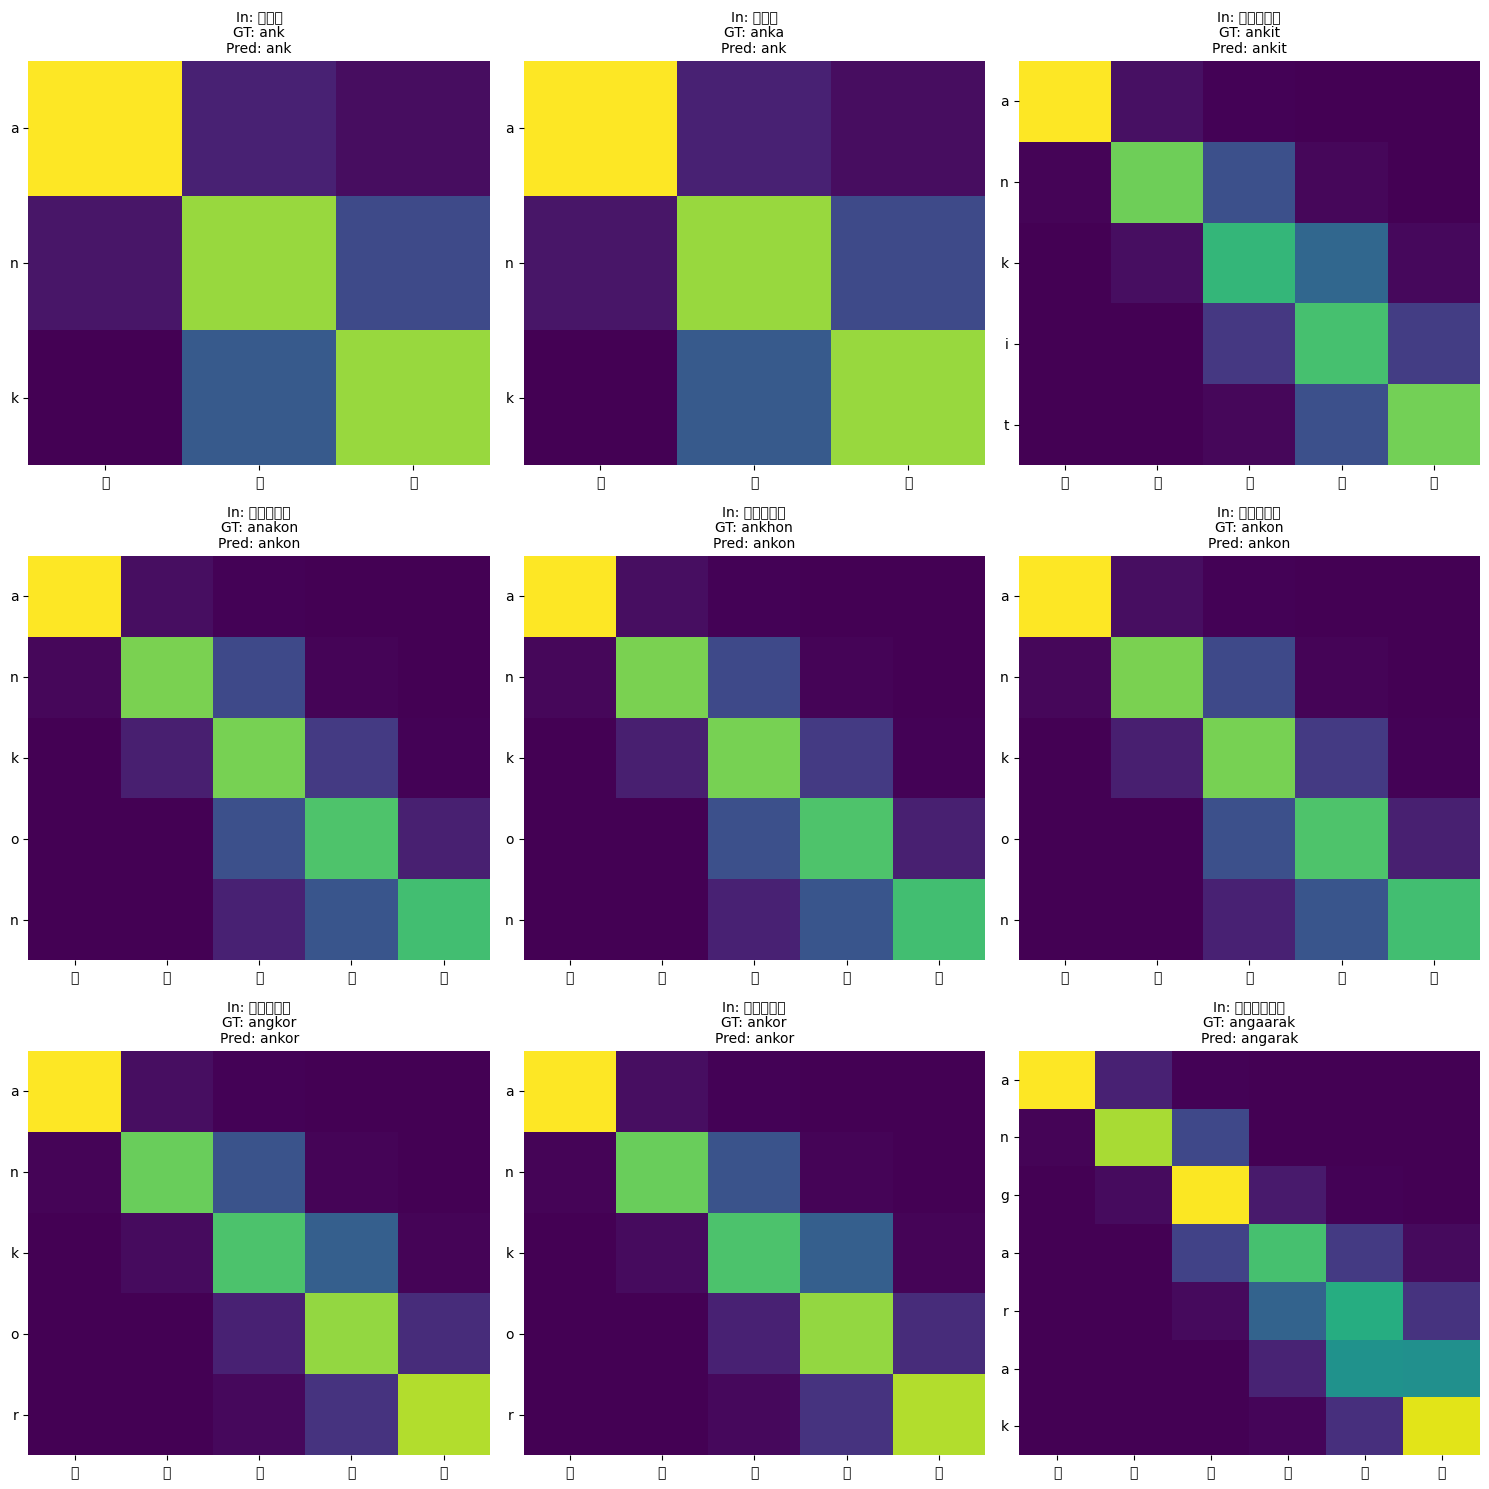


Random Samples:
Input: अंकित
True: ankit
Pred: ankit

Input: अंक
True: ank
Pred: ank

Input: अंकों
True: ankon
Pred: ankon

Input: अंकों
True: anakon
Pred: ankon

Input: अंकोर
True: angkor
Pred: ankor

Input: अंक
True: anka
Pred: ank

Input: अंकोर
True: ankor
Pred: ankor

Input: अंगारक
True: angaarak
Pred: angarak

Input: अंकों
True: ankhon
Pred: ankon



In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
import random
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties

# =======================
# Best Configuration
# =======================
best_config = {
    'embedding_dim': 256,
    'hidden_dim': 256,
    'enc_layers': 2,
    'dec_layers': 2,
    'cell_type': 'LSTM',
    'dropout': 0.5,
    'epochs': 15,
    'beam_size': 5,
    'attention_type': 'concat',
    'batch_size': 256,
    'learning_rate': 0.001
}

# =======================
# Vocabulary
# =======================
class Vocab:
    def __init__(self):
        self.char2idx = {"<pad>": 0, "<sos>": 1, "<eos>": 2}
        self.idx2char = {0: "<pad>", 1: "<sos>", 2: "<eos>"}
        self.size = 3

    def build(self, texts):
        for text in texts:
            for char in text:
                if char not in self.char2idx:
                    self.char2idx[char] = self.size
                    self.idx2char[self.size] = char
                    self.size += 1

    def encode(self, text):
        return [self.char2idx[c] for c in text]

    def decode(self, idxs):
        return ''.join([self.idx2char[i] for i in idxs if i not in [0, 1, 2]])

# =======================
# Dataset
# =======================
class TransliterationDataset(Dataset):
    def __init__(self, filepath, inp_vocab, out_vocab, is_test=False):
        self.pairs = []
        with open(filepath, encoding='utf-8') as f:
            for line in f:
                fields = line.strip().split('\t')
                if len(fields) < 2:
                    continue
                lat, dev = fields[0], fields[1]
                self.pairs.append((lat, dev))
        if not is_test:
            inp_vocab.build([p[0] for p in self.pairs])
            out_vocab.build([p[1] for p in self.pairs])
        self.inp_vocab = inp_vocab
        self.out_vocab = out_vocab
        self.is_test = is_test

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        lat, dev = self.pairs[idx]
        x = self.inp_vocab.encode(lat)
        if self.is_test:
            return torch.tensor(x), lat, dev
        y = [self.out_vocab.char2idx["<sos>"]] + self.out_vocab.encode(dev) + [self.out_vocab.char2idx["<eos>"]]
        return torch.tensor(x), torch.tensor(y), lat, dev

def collate_fn(batch):
    if len(batch[0]) == 3:  # Test batch
        x_batch, lat, dev = zip(*batch)
        x_lens = [len(x) for x in x_batch]
        x_pad = nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value=0)
        return x_pad, lat, dev, torch.tensor(x_lens)
    else:  # Train/val batch
        x_batch, y_batch, lat, dev = zip(*batch)
        x_lens = [len(x) for x in x_batch]
        y_lens = [len(y) for y in y_batch]
        x_pad = nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value=0)
        y_pad = nn.utils.rnn.pad_sequence(y_batch, batch_first=True, padding_value=0)
        return x_pad, y_pad, torch.tensor(x_lens), torch.tensor(y_lens), lat, dev

# =======================
# Model Components
# =======================
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, cell_type, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        rnn_class = {"GRU": nn.GRU, "LSTM": nn.LSTM, "RNN": nn.RNN}[cell_type]
        self.rnn = rnn_class(emb_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        outputs, hidden = self.rnn(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, hidden_dim, attention_type='general'):
        super().__init__()
        self.attention_type = attention_type
        if attention_type == 'general':
            self.attn = nn.Linear(hidden_dim, hidden_dim)
        elif attention_type == 'concat':
            self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
            self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask=None):
        batch_size, src_len, hidden_dim = encoder_outputs.size()
        
        if self.attention_type == 'general':
            energy = torch.bmm(encoder_outputs, self.attn(hidden).unsqueeze(2)).squeeze(2)
        elif self.attention_type == 'concat':
            hidden_expanded = hidden.unsqueeze(1).repeat(1, src_len, 1)
            concat = torch.cat((hidden_expanded, encoder_outputs), dim=2)
            energy = self.v(torch.tanh(self.attn(concat))).squeeze(2)
        else:  # dot
            energy = torch.bmm(encoder_outputs, hidden.unsqueeze(2)).squeeze(2)
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        attention_weights = F.softmax(energy, dim=1)
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context, attention_weights

class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, cell_type, dropout, attention_type):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        rnn_class = {"GRU": nn.GRU, "LSTM": nn.LSTM, "RNN": nn.RNN}[cell_type]
        self.rnn = rnn_class(emb_dim + hidden_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.attention = Attention(hidden_dim, attention_type)
        self.out = nn.Linear(hidden_dim * 2, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_token, hidden, encoder_outputs, mask=None):
        if isinstance(hidden, tuple):  # LSTM
            attn_hidden = hidden[0][-1]
        else:  # GRU/RNN
            attn_hidden = hidden[-1]
        
        context, attn_weights = self.attention(attn_hidden, encoder_outputs, mask)
        embedded = self.embedding(input_token)
        rnn_input = torch.cat((embedded, context), dim=1).unsqueeze(1)
        output, hidden = self.rnn(rnn_input, hidden)
        
        if isinstance(hidden, tuple):
            output_hidden = hidden[0][-1]
        else:
            output_hidden = hidden[-1]
        
        output = torch.cat((output_hidden, context), dim=1)
        output = self.dropout(output)
        prediction = self.out(output)
        return prediction, hidden, attn_weights

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def create_mask(self, src_lens, max_len):
        batch_size = len(src_lens)
        mask = torch.zeros(batch_size, max_len, device=self.device)
        for i, length in enumerate(src_lens):
            mask[i, :length] = 1
        return mask

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        src_data, src_lens = src
        encoder_outputs, enc_hidden = self.encoder(src_data, src_lens)
        batch_size, trg_len = trg.size()
        vocab_size = self.decoder.out.out_features
        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)
        
        src_len = encoder_outputs.size(1)
        mask = self.create_mask(src_lens, src_len)

        if isinstance(enc_hidden, tuple):
            dec_hidden = enc_hidden
        else:
            dec_hidden = enc_hidden

        input_token = trg[:, 0]
        for t in range(1, trg_len):
            output, dec_hidden, _ = self.decoder(input_token, dec_hidden, encoder_outputs, mask)
            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_token = trg[:, t] if teacher_force else top1
            
        return outputs

    def predict(self, src, src_lens, max_len=30):
        self.eval()
        with torch.no_grad():
            encoder_outputs, enc_hidden = self.encoder(src, src_lens)
            src_len = encoder_outputs.size(1)
            mask = self.create_mask(src_lens.tolist(), src_len)
            
            if isinstance(enc_hidden, tuple):
                dec_hidden = enc_hidden
            else:
                dec_hidden = enc_hidden
            
            input_token = torch.tensor([1], device=self.device)
            output_seq = []
            attention_weights = []
            
            for _ in range(max_len):
                output, dec_hidden, attn_weights = self.decoder(input_token, dec_hidden, encoder_outputs, mask)
                top1 = output.argmax(1)
                if top1.item() == 2:  # <eos> token
                    break
                output_seq.append(top1.item())
                attention_weights.append(attn_weights.cpu().numpy())
                input_token = top1
                
        return output_seq, attention_weights

# =======================
# Training and Evaluation
# =======================
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    
    for batch in loader:
        src, trg, src_lens, _, _, _ = batch
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model((src, src_lens), trg)
        
        # Calculate loss
        output_dim = output.shape[-1]
        loss = criterion(output[:, 1:].reshape(-1, output_dim), trg[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        pred = output.argmax(dim=2)
        mask = (trg[:, 1:] != 0)
        correct = ((pred[:, 1:] == trg[:, 1:]) & mask).sum().item()
        total_correct += correct
        total_tokens += mask.sum().item()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    accuracy = (total_correct / total_tokens) * 100 if total_tokens > 0 else 0
    return avg_loss, accuracy

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_tokens = 0
    
    with torch.no_grad():
        for batch in loader:
            src, trg, src_lens, _, _, _ = batch
            src, trg = src.to(device), trg.to(device)
            output = model((src, src_lens), trg, teacher_forcing_ratio=0)
            
            # Calculate loss
            output_dim = output.shape[-1]
            loss = criterion(output[:, 1:].reshape(-1, output_dim), trg[:, 1:].reshape(-1))
            
            # Calculate accuracy
            pred = output.argmax(dim=2)
            mask = (trg[:, 1:] != 0)
            correct = ((pred[:, 1:] == trg[:, 1:]) & mask).sum().item()
            total_correct += correct
            total_tokens += mask.sum().item()
            total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    accuracy = (total_correct / total_tokens) * 100 if total_tokens > 0 else 0
    return avg_loss, accuracy

# =======================
# Attention Visualization
# =======================
def show_attention_grid(samples):
    # Try to load a font that supports Devanagari script
    # Use a default font if specific font not available
    try:
        devanagari_font = FontProperties(family='Nirmala UI', size=10)
    except:
        devanagari_font = FontProperties(size=10)

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()

    for idx, (input_seq, true_output, predicted_output, attentions) in enumerate(samples):
        if idx >= 9:  # Only show 9 samples in the 3x3 grid
            break
            
        ax = axes[idx]
        input_chars = list(input_seq)
        output_chars = list(predicted_output)
        attn_matrix = np.array(attentions).squeeze(1)

        sns.heatmap(
            attn_matrix[:len(output_chars), :len(input_chars)],
            xticklabels=input_chars,
            yticklabels=output_chars,
            cmap='viridis',
            ax=ax,
            cbar=False
        )
        ax.set_yticklabels(ax.get_yticklabels(), fontproperties=devanagari_font, rotation=0)
        ax.set_title(f"In: {input_seq}\nGT: {true_output}\nPred: {predicted_output}", 
                     fontsize=9, fontproperties=devanagari_font)
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Hide any unused subplots
    for j in range(len(samples), 9):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig('attention_heatmap.png', dpi=300, bbox_inches='tight')
    wandb.log({"attention_heatmap": wandb.Image('attention_heatmap.png')})
    plt.show()
    plt.close()

# =======================
# Main Execution
# =======================
def main():
    wandb.init(config=best_config, project="dakshina-translit-test")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize vocabularies
    inp_vocab = Vocab()
    out_vocab = Vocab()

    # Load datasets
    train_data = TransliterationDataset("/kaggle/input/devnagiridata/hi.translit.sampled.train.tsv", inp_vocab, out_vocab)
    dev_data = TransliterationDataset("/kaggle/input/devnagiridata/hi.translit.sampled.dev.tsv", inp_vocab, out_vocab)
    test_data = TransliterationDataset("/kaggle/input/devnagiridata/hi.translit.sampled.test.tsv", inp_vocab, out_vocab, is_test=True)

    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=best_config['batch_size'], 
                            shuffle=True, collate_fn=collate_fn)
    dev_loader = DataLoader(dev_data, batch_size=best_config['batch_size'],
                          shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_data, batch_size=1, shuffle=False, collate_fn=collate_fn)

    # Initialize model
    encoder = Encoder(inp_vocab.size, best_config['embedding_dim'], 
                     best_config['hidden_dim'], best_config['enc_layers'], 
                     best_config['cell_type'], best_config['dropout'])
    
    decoder = Decoder(out_vocab.size, best_config['embedding_dim'],
                     best_config['hidden_dim'], best_config['dec_layers'],
                     best_config['cell_type'], best_config['dropout'],
                     best_config['attention_type'])
    
    model = Seq2Seq(encoder, decoder, device).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_config['learning_rate'])
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    # Training loop
    best_val_loss = float('inf')
    for epoch in range(best_config['epochs']):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, dev_loader, criterion, device)
        
        print(f"\nEpoch {epoch+1}/{best_config['epochs']}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc
        })
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")

    # Test evaluation
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    
    total_correct = 0
    total_samples = 0
    predictions = []
    attention_samples = []
    
    with torch.no_grad():
        for batch in test_loader:
            src, lat, dev, src_lens = batch
            src = src.to(device)
            pred_ids, attention_weights = model.predict(src, src_lens)
            pred_str = out_vocab.decode(pred_ids)
            true_str = dev[0]
            
            predictions.append({
                'input': lat[0],
                'true': true_str,
                'pred': pred_str
            })
            
            # Save attention weights for visualization
            attention_samples.append((lat[0], true_str, pred_str, attention_weights))
            
            if pred_str == true_str:
                total_correct += 1
            total_samples += 1
            
            # Only collect 9 samples for visualization
            if len(attention_samples) >= 10:
                break

    # Calculate accuracy
    accuracy = 100 * total_correct / total_samples
    print(f"\nTest Accuracy: {accuracy:.2f}%")
    wandb.log({"test_acc": accuracy})

    # Visualize attention for 9 samples
    show_attention_grid(attention_samples)

    # Create and log a table of predictions
    table = wandb.Table(columns=["Input", "True", "Predicted"])
    for p in predictions[:20]:  # Log first 20 predictions
        table.add_data(p['input'], p['true'], p['pred'])
    
    wandb.log({
        "predictions": table,
        "test_accuracy": accuracy
    })
    
    # Save predictions
    with open("test_predictions.txt", "w", encoding="utf-8") as f:
        f.write(f"Test Accuracy: {accuracy:.2f}%\n\n")
        for p in predictions[:20]:
            f.write(f"Input: {p['input']}\n")
            f.write(f"True: {p['true']}\n")
            f.write(f"Pred: {p['pred']}\n\n")
    
    # Print random samples
    print("\nRandom Samples:")
    samples = random.sample(predictions, min(30, len(predictions)))
    for sample in samples:
        print(f"Input: {sample['input']}")
        print(f"True: {sample['true']}")
        print(f"Pred: {sample['pred']}\n")

if __name__ == "__main__":
    main()

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_acc,▁
test_accuracy,▁
train_acc,▁▆▇▇▇▇█████████
train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁
val_acc,▁▆▇▇▇█▇████████
val_loss,█▃▂▂▁▂▂▂▂▁▂▁▁▂▁
epoch,15
test_acc,44.44444
test_accuracy,44.44444
train_acc,83.37274



Epoch 1/15
Train Loss: 1.6923 | Train Char Acc: 48.68% | Train Word Acc: 5.39%
Val Loss: 0.9486 | Val Char Acc: 69.98% | Val Word Acc: 28.32%
Best model saved!

Epoch 2/15
Train Loss: 0.8568 | Train Char Acc: 73.71% | Train Word Acc: 21.05%
Val Loss: 0.8781 | Val Char Acc: 71.93% | Val Word Acc: 32.58%
Best model saved!

Epoch 3/15
Train Loss: 0.7478 | Train Char Acc: 76.81% | Train Word Acc: 24.22%
Val Loss: 0.8738 | Val Char Acc: 73.08% | Val Word Acc: 38.07%
Best model saved!

Epoch 4/15
Train Loss: 0.6857 | Train Char Acc: 78.68% | Train Word Acc: 24.36%
Val Loss: 0.8099 | Val Char Acc: 74.70% | Val Word Acc: 39.10%
Best model saved!

Epoch 5/15
Train Loss: 0.6487 | Train Char Acc: 79.70% | Train Word Acc: 26.29%
Val Loss: 0.8061 | Val Char Acc: 74.79% | Val Word Acc: 40.32%
Best model saved!

Epoch 6/15
Train Loss: 0.6261 | Train Char Acc: 80.36% | Train Word Acc: 27.30%
Val Loss: 0.7846 | Val Char Acc: 75.52% | Val Word Acc: 40.82%
Best model saved!

Epoch 7/15
Train Loss: 0.591

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py

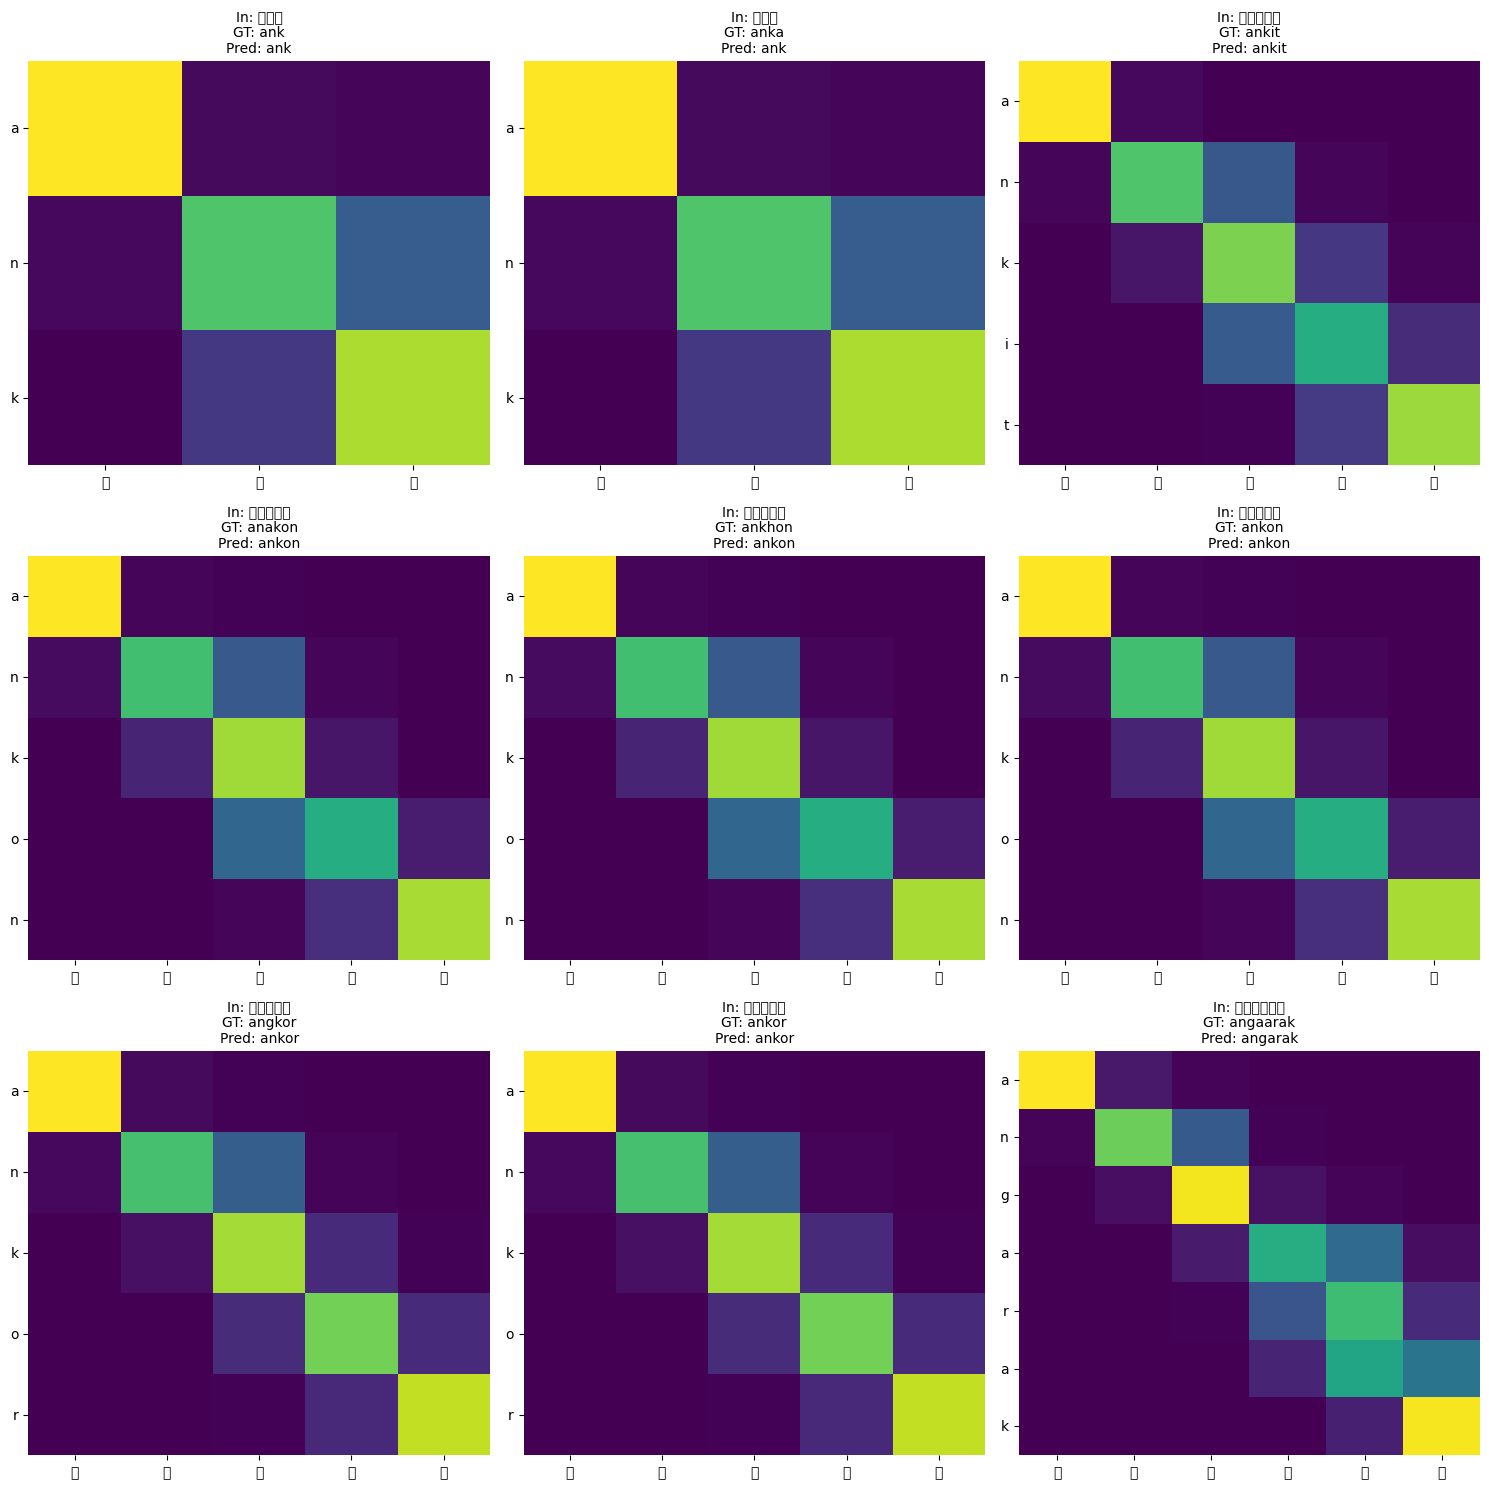


Random Samples:
Input: अंकों
True: anakon
Pred: ankon
Correct: False

Input: अंगारक
True: angarak
Pred: angarak
Correct: True

Input: अंकोर
True: ankor
Pred: ankor
Correct: True

Input: अंकों
True: ankon
Pred: ankon
Correct: True

Input: अंक
True: ank
Pred: ank
Correct: True

Input: अंकोर
True: angkor
Pred: ankor
Correct: False

Input: अंगारक
True: angaarak
Pred: angarak
Correct: False

Input: अंकों
True: ankhon
Pred: ankon
Correct: False

Input: अंकित
True: ankit
Pred: ankit
Correct: True

Input: अंक
True: anka
Pred: ank
Correct: False



In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
import random
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties

# =======================
# Best Configuration
# =======================
best_config = {
    'embedding_dim': 256,
    'hidden_dim': 256,
    'enc_layers': 2,
    'dec_layers': 2,
    'cell_type': 'LSTM',
    'dropout': 0.5,
    'epochs': 15,
    'beam_size': 5,
    'attention_type': 'concat',
    'batch_size': 256,
    'learning_rate': 0.001
}

# =======================
# Vocabulary
# =======================
class Vocab:
    def __init__(self):
        self.char2idx = {"<pad>": 0, "<sos>": 1, "<eos>": 2}
        self.idx2char = {0: "<pad>", 1: "<sos>", 2: "<eos>"}
        self.size = 3

    def build(self, texts):
        for text in texts:
            for char in text:
                if char not in self.char2idx:
                    self.char2idx[char] = self.size
                    self.idx2char[self.size] = char
                    self.size += 1

    def encode(self, text):
        return [self.char2idx[c] for c in text]

    def decode(self, idxs):
        return ''.join([self.idx2char[i] for i in idxs if i not in [0, 1, 2]])

# =======================
# Dataset
# =======================
class TransliterationDataset(Dataset):
    def __init__(self, filepath, inp_vocab, out_vocab, is_test=False):
        self.pairs = []
        with open(filepath, encoding='utf-8') as f:
            for line in f:
                fields = line.strip().split('\t')
                if len(fields) < 2:
                    continue
                lat, dev = fields[0], fields[1]
                self.pairs.append((lat, dev))
        if not is_test:
            inp_vocab.build([p[0] for p in self.pairs])
            out_vocab.build([p[1] for p in self.pairs])
        self.inp_vocab = inp_vocab
        self.out_vocab = out_vocab
        self.is_test = is_test

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        lat, dev = self.pairs[idx]
        x = self.inp_vocab.encode(lat)
        if self.is_test:
            return torch.tensor(x), lat, dev
        y = [self.out_vocab.char2idx["<sos>"]] + self.out_vocab.encode(dev) + [self.out_vocab.char2idx["<eos>"]]
        return torch.tensor(x), torch.tensor(y), lat, dev

def collate_fn(batch):
    if len(batch[0]) == 3:  # Test batch
        x_batch, lat, dev = zip(*batch)
        x_lens = [len(x) for x in x_batch]
        x_pad = nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value=0)
        return x_pad, lat, dev, torch.tensor(x_lens)
    else:  # Train/val batch
        x_batch, y_batch, lat, dev = zip(*batch)
        x_lens = [len(x) for x in x_batch]
        y_lens = [len(y) for y in y_batch]
        x_pad = nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value=0)
        y_pad = nn.utils.rnn.pad_sequence(y_batch, batch_first=True, padding_value=0)
        return x_pad, y_pad, torch.tensor(x_lens), torch.tensor(y_lens), lat, dev

# =======================
# Model Components
# =======================
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, cell_type, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        rnn_class = {"GRU": nn.GRU, "LSTM": nn.LSTM, "RNN": nn.RNN}[cell_type]
        self.rnn = rnn_class(emb_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        outputs, hidden = self.rnn(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, hidden_dim, attention_type='general'):
        super().__init__()
        self.attention_type = attention_type
        if attention_type == 'general':
            self.attn = nn.Linear(hidden_dim, hidden_dim)
        elif attention_type == 'concat':
            self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
            self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask=None):
        batch_size, src_len, hidden_dim = encoder_outputs.size()
        
        if self.attention_type == 'general':
            energy = torch.bmm(encoder_outputs, self.attn(hidden).unsqueeze(2)).squeeze(2)
        elif self.attention_type == 'concat':
            hidden_expanded = hidden.unsqueeze(1).repeat(1, src_len, 1)
            concat = torch.cat((hidden_expanded, encoder_outputs), dim=2)
            energy = self.v(torch.tanh(self.attn(concat))).squeeze(2)
        else:  # dot
            energy = torch.bmm(encoder_outputs, hidden.unsqueeze(2)).squeeze(2)
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        attention_weights = F.softmax(energy, dim=1)
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context, attention_weights

class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, cell_type, dropout, attention_type):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        rnn_class = {"GRU": nn.GRU, "LSTM": nn.LSTM, "RNN": nn.RNN}[cell_type]
        self.rnn = rnn_class(emb_dim + hidden_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.attention = Attention(hidden_dim, attention_type)
        self.out = nn.Linear(hidden_dim * 2, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_token, hidden, encoder_outputs, mask=None):
        if isinstance(hidden, tuple):  # LSTM
            attn_hidden = hidden[0][-1]
        else:  # GRU/RNN
            attn_hidden = hidden[-1]
        
        context, attn_weights = self.attention(attn_hidden, encoder_outputs, mask)
        embedded = self.embedding(input_token)
        rnn_input = torch.cat((embedded, context), dim=1).unsqueeze(1)
        output, hidden = self.rnn(rnn_input, hidden)
        
        if isinstance(hidden, tuple):
            output_hidden = hidden[0][-1]
        else:
            output_hidden = hidden[-1]
        
        output = torch.cat((output_hidden, context), dim=1)
        output = self.dropout(output)
        prediction = self.out(output)
        return prediction, hidden, attn_weights

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def create_mask(self, src_lens, max_len):
        batch_size = len(src_lens)
        mask = torch.zeros(batch_size, max_len, device=self.device)
        for i, length in enumerate(src_lens):
            mask[i, :length] = 1
        return mask

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        src_data, src_lens = src
        encoder_outputs, enc_hidden = self.encoder(src_data, src_lens)
        batch_size, trg_len = trg.size()
        vocab_size = self.decoder.out.out_features
        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)
        
        src_len = encoder_outputs.size(1)
        mask = self.create_mask(src_lens, src_len)

        if isinstance(enc_hidden, tuple):
            dec_hidden = enc_hidden
        else:
            dec_hidden = enc_hidden

        input_token = trg[:, 0]
        for t in range(1, trg_len):
            output, dec_hidden, _ = self.decoder(input_token, dec_hidden, encoder_outputs, mask)
            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_token = trg[:, t] if teacher_force else top1
            
        return outputs

    def predict(self, src, src_lens, max_len=30):
        self.eval()
        with torch.no_grad():
            encoder_outputs, enc_hidden = self.encoder(src, src_lens)
            src_len = encoder_outputs.size(1)
            mask = self.create_mask(src_lens.tolist(), src_len)
            
            if isinstance(enc_hidden, tuple):
                dec_hidden = enc_hidden
            else:
                dec_hidden = enc_hidden
            
            input_token = torch.tensor([1], device=self.device)
            output_seq = []
            attention_weights = []
            
            for _ in range(max_len):
                output, dec_hidden, attn_weights = self.decoder(input_token, dec_hidden, encoder_outputs, mask)
                top1 = output.argmax(1)
                if top1.item() == 2:  # <eos> token
                    break
                output_seq.append(top1.item())
                attention_weights.append(attn_weights.cpu().numpy())
                input_token = top1
                
        return output_seq, attention_weights

# =======================
# Training and Evaluation with Word-Level Accuracy
# =======================
def train(model, loader, criterion, optimizer, device, out_vocab):
    model.train()
    total_loss = 0
    total_correct_chars = 0
    total_chars = 0
    
    # Word-level tracking
    total_correct_words = 0
    total_words = 0
    
    for batch in loader:
        src, trg, src_lens, _, lat, dev = batch
        src, trg = src.to(device), trg.to(device)
        
        optimizer.zero_grad()
        output = model((src, src_lens), trg)
        
        # Calculate loss
        output_dim = output.shape[-1]
        loss = criterion(output[:, 1:].reshape(-1, output_dim), trg[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        
        # Calculate character-level accuracy
        pred = output.argmax(dim=2)
        mask = (trg[:, 1:] != 0)  # Ignore padding
        correct_chars = ((pred[:, 1:] == trg[:, 1:]) & mask).sum().item()
        total_correct_chars += correct_chars
        total_chars += mask.sum().item()
        
        # Calculate word-level accuracy
        batch_size = trg.size(0)
        for i in range(batch_size):
            # Get predicted sequence without padding, sos, eos
            pred_seq = [idx.item() for idx in pred[i, 1:] if idx.item() not in [0, 1, 2]]
            # Convert to string
            pred_word = out_vocab.decode(pred_seq)
            
            # Get true word
            true_word = dev[i]
            
            # Increment counts
            total_words += 1
            if pred_word == true_word:
                total_correct_words += 1
                
        total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    char_accuracy = (total_correct_chars / total_chars) * 100 if total_chars > 0 else 0
    word_accuracy = (total_correct_words / total_words) * 100 if total_words > 0 else 0
    
    return avg_loss, char_accuracy, word_accuracy

def evaluate(model, loader, criterion, device, out_vocab):
    model.eval()
    total_loss = 0
    total_correct_chars = 0
    total_chars = 0
    
    # Word-level tracking
    total_correct_words = 0
    total_words = 0
    
    with torch.no_grad():
        for batch in loader:
            src, trg, src_lens, _, lat, dev = batch
            src, trg = src.to(device), trg.to(device)
            
            output = model((src, src_lens), trg, teacher_forcing_ratio=0)
            
            # Calculate loss
            output_dim = output.shape[-1]
            loss = criterion(output[:, 1:].reshape(-1, output_dim), trg[:, 1:].reshape(-1))
            
            # Calculate character-level accuracy
            pred = output.argmax(dim=2)
            mask = (trg[:, 1:] != 0)  # Ignore padding
            correct_chars = ((pred[:, 1:] == trg[:, 1:]) & mask).sum().item()
            total_correct_chars += correct_chars
            total_chars += mask.sum().item()
            
            # Calculate word-level accuracy
            batch_size = trg.size(0)
            for i in range(batch_size):
                # Get predicted sequence without padding, sos, eos
                pred_seq = [idx.item() for idx in pred[i, 1:] if idx.item() not in [0, 1, 2]]
                # Convert to string
                pred_word = out_vocab.decode(pred_seq)
                
                # Get true word
                true_word = dev[i]
                
                # Increment counts
                total_words += 1
                if pred_word == true_word:
                    total_correct_words += 1
                    
            total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    char_accuracy = (total_correct_chars / total_chars) * 100 if total_chars > 0 else 0
    word_accuracy = (total_correct_words / total_words) * 100 if total_words > 0 else 0
    
    return avg_loss, char_accuracy, word_accuracy

# =======================
# Attention Visualization
# =======================
def show_attention_grid(samples):
    # Try to load a font that supports Devanagari script
    # Use a default font if specific font not available
    try:
        devanagari_font = FontProperties(family='Nirmala UI', size=10)
    except:
        devanagari_font = FontProperties(size=10)

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()

    for idx, (input_seq, true_output, predicted_output, attentions) in enumerate(samples):
        if idx >= 9:  # Only show 9 samples in the 3x3 grid
            break
            
        ax = axes[idx]
        input_chars = list(input_seq)
        output_chars = list(predicted_output)
        attn_matrix = np.array(attentions).squeeze(1)

        sns.heatmap(
            attn_matrix[:len(output_chars), :len(input_chars)],
            xticklabels=input_chars,
            yticklabels=output_chars,
            cmap='viridis',
            ax=ax,
            cbar=False
        )
        ax.set_yticklabels(ax.get_yticklabels(), fontproperties=devanagari_font, rotation=0)
        ax.set_title(f"In: {input_seq}\nGT: {true_output}\nPred: {predicted_output}", 
                     fontsize=9, fontproperties=devanagari_font)
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Hide any unused subplots
    for j in range(len(samples), 9):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig('attention_heatmap.png', dpi=300, bbox_inches='tight')
    wandb.log({"attention_heatmap": wandb.Image('attention_heatmap.png')})
    plt.show()
    plt.close()

# =======================
# Main Execution
# =======================
def main():
    wandb.init(config=best_config, project="dakshina-translit-test")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize vocabularies
    inp_vocab = Vocab()
    out_vocab = Vocab()

    # Load datasets
    train_data = TransliterationDataset("/kaggle/input/devnagiridata/hi.translit.sampled.train.tsv", inp_vocab, out_vocab)
    dev_data = TransliterationDataset("/kaggle/input/devnagiridata/hi.translit.sampled.dev.tsv", inp_vocab, out_vocab)
    test_data = TransliterationDataset("/kaggle/input/devnagiridata/hi.translit.sampled.test.tsv", inp_vocab, out_vocab, is_test=True)

    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=best_config['batch_size'], 
                            shuffle=True, collate_fn=collate_fn)
    dev_loader = DataLoader(dev_data, batch_size=best_config['batch_size'],
                          shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_data, batch_size=1, shuffle=False, collate_fn=collate_fn)

    # Initialize model
    encoder = Encoder(inp_vocab.size, best_config['embedding_dim'], 
                     best_config['hidden_dim'], best_config['enc_layers'], 
                     best_config['cell_type'], best_config['dropout'])
    
    decoder = Decoder(out_vocab.size, best_config['embedding_dim'],
                     best_config['hidden_dim'], best_config['dec_layers'],
                     best_config['cell_type'], best_config['dropout'],
                     best_config['attention_type'])
    
    model = Seq2Seq(encoder, decoder, device).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_config['learning_rate'])
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    # Training loop
    best_val_loss = float('inf')
    for epoch in range(best_config['epochs']):
        train_loss, train_char_acc, train_word_acc = train(model, train_loader, criterion, optimizer, device, out_vocab)
        val_loss, val_char_acc, val_word_acc = evaluate(model, dev_loader, criterion, device, out_vocab)
        
        print(f"\nEpoch {epoch+1}/{best_config['epochs']}")
        print(f"Train Loss: {train_loss:.4f} | Train Char Acc: {train_char_acc:.2f}% | Train Word Acc: {train_word_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Char Acc: {val_char_acc:.2f}% | Val Word Acc: {val_word_acc:.2f}%")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_char_acc": train_char_acc,
            "train_word_acc": train_word_acc,
            "val_loss": val_loss,
            "val_char_acc": val_char_acc,
            "val_word_acc": val_word_acc
        })
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")

    # Test evaluation
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    
    total_char_correct = 0
    total_chars = 0
    total_word_correct = 0
    total_words = 0
    predictions = []
    attention_samples = []
    
    with torch.no_grad():
        for batch in test_loader:
            src, lat, dev, src_lens = batch
            src = src.to(device)
            pred_ids, attention_weights = model.predict(src, src_lens)
            pred_str = out_vocab.decode(pred_ids)
            true_str = dev[0]
            
            # Word-level accuracy
            total_words += 1
            if pred_str == true_str:
                total_word_correct += 1
            
            # Character-level accuracy (for comparison)
            min_len = min(len(pred_str), len(true_str))
            for i in range(min_len):
                total_chars += 1
                if pred_str[i] == true_str[i]:
                    total_char_correct += 1
            # Count remaining characters in longer string as errors
            total_chars += abs(len(pred_str) - len(true_str))
            
            predictions.append({
                'input': lat[0],
                'true': true_str,
                'pred': pred_str
            })
            
            # Save attention weights for visualization
            attention_samples.append((lat[0], true_str, pred_str, attention_weights))
            
            # Only collect 9 samples for visualization
            if len(attention_samples) >= 10:
                break

    # Calculate accuracies
    word_accuracy = 100 * total_word_correct / total_words if total_words > 0 else 0
    char_accuracy = 100 * total_char_correct / total_chars if total_chars > 0 else 0
    
    print(f"\nTest Word Accuracy: {word_accuracy:.2f}%")
    print(f"Test Character Accuracy: {char_accuracy:.2f}%")
    
    wandb.log({
        "test_word_acc": word_accuracy,
        "test_char_acc": char_accuracy
    })

    # Visualize attention for 9 samples
    show_attention_grid(attention_samples)

    # Create and log a table of predictions
    table = wandb.Table(columns=["Input", "True", "Predicted", "Correct"])
    for p in predictions[:20]:  # Log first 20 predictions
        is_correct = p['true'] == p['pred']
        table.add_data(p['input'], p['true'], p['pred'], is_correct)
    
    wandb.log({
        "predictions": table,
        "test_word_accuracy": word_accuracy,
        "test_char_accuracy": char_accuracy
    })
    
    # Save predictions
    with open("test_predictions.txt", "w", encoding="utf-8") as f:
        f.write(f"Test Word Accuracy: {word_accuracy:.2f}%\n")
        f.write(f"Test Character Accuracy: {char_accuracy:.2f}%\n\n")
        for p in predictions[:20]:
            f.write(f"Input: {p['input']}\n")
            f.write(f"True: {p['true']}\n")
            f.write(f"Pred: {p['pred']}\n")
            f.write(f"Correct: {p['true'] == p['pred']}\n\n")
    
    # Print random samples
    print("\nRandom Samples:")
    samples = random.sample(predictions, min(30, len(predictions)))
    for sample in samples:
        print(f"Input: {sample['input']}")
        print(f"True: {sample['true']}")
        print(f"Pred: {sample['pred']}")
        print(f"Correct: {sample['true'] == sample['pred']}\n")

if __name__ == "__main__":
    main()

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
import random
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties

# =======================
# Best Configuration
# =======================
best_config = {
    'embedding_dim': 256,
    'hidden_dim': 256,
    'enc_layers': 2,
    'dec_layers': 2,
    'cell_type': 'LSTM',
    'dropout': 0.5,
    'epochs': 15,
    'beam_size': 5,
    'attention_type': 'concat',
    'batch_size': 256,
    'learning_rate': 0.001
}

# =======================
# Vocabulary
# =======================
class Vocab:
    def __init__(self):
        self.char2idx = {"<pad>": 0, "<sos>": 1, "<eos>": 2}
        self.idx2char = {0: "<pad>", 1: "<sos>", 2: "<eos>"}
        self.size = 3

    def build(self, texts):
        for text in texts:
            for char in text:
                if char not in self.char2idx:
                    self.char2idx[char] = self.size
                    self.idx2char[self.size] = char
                    self.size += 1

    def encode(self, text):
        return [self.char2idx[c] for c in text]

    def decode(self, idxs):
        return ''.join([self.idx2char[i] for i in idxs if i not in [0, 1, 2]])

# =======================
# Dataset
# =======================
class TransliterationDataset(Dataset):
    def __init__(self, filepath, inp_vocab, out_vocab, is_test=False):
        self.pairs = []
        with open(filepath, encoding='utf-8') as f:
            for line in f:
                fields = line.strip().split('\t')
                if len(fields) < 2:
                    continue
                lat, dev = fields[0], fields[1]
                self.pairs.append((lat, dev))
        if not is_test:
            inp_vocab.build([p[0] for p in self.pairs])
            out_vocab.build([p[1] for p in self.pairs])
        self.inp_vocab = inp_vocab
        self.out_vocab = out_vocab
        self.is_test = is_test

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        lat, dev = self.pairs[idx]
        x = self.inp_vocab.encode(lat)
        if self.is_test:
            return torch.tensor(x), lat, dev
        y = [self.out_vocab.char2idx["<sos>"]] + self.out_vocab.encode(dev) + [self.out_vocab.char2idx["<eos>"]]
        return torch.tensor(x), torch.tensor(y), lat, dev

def collate_fn(batch):
    if len(batch[0]) == 3:  # Test batch
        x_batch, lat, dev = zip(*batch)
        x_lens = [len(x) for x in x_batch]
        x_pad = nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value=0)
        return x_pad, lat, dev, torch.tensor(x_lens)
    else:  # Train/val batch
        x_batch, y_batch, lat, dev = zip(*batch)
        x_lens = [len(x) for x in x_batch]
        y_lens = [len(y) for y in y_batch]
        x_pad = nn.utils.rnn.pad_sequence(x_batch, batch_first=True, padding_value=0)
        y_pad = nn.utils.rnn.pad_sequence(y_batch, batch_first=True, padding_value=0)
        return x_pad, y_pad, torch.tensor(x_lens), torch.tensor(y_lens), lat, dev

# =======================
# Model Components
# =======================
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, cell_type, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        rnn_class = {"GRU": nn.GRU, "LSTM": nn.LSTM, "RNN": nn.RNN}[cell_type]
        self.rnn = rnn_class(emb_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        outputs, hidden = self.rnn(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, hidden_dim, attention_type='general'):
        super().__init__()
        self.attention_type = attention_type
        if attention_type == 'general':
            self.attn = nn.Linear(hidden_dim, hidden_dim)
        elif attention_type == 'concat':
            self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
            self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs, mask=None):
        batch_size, src_len, hidden_dim = encoder_outputs.size()
        
        if self.attention_type == 'general':
            energy = torch.bmm(encoder_outputs, self.attn(hidden).unsqueeze(2)).squeeze(2)
        elif self.attention_type == 'concat':
            hidden_expanded = hidden.unsqueeze(1).repeat(1, src_len, 1)
            concat = torch.cat((hidden_expanded, encoder_outputs), dim=2)
            energy = self.v(torch.tanh(self.attn(concat))).squeeze(2)
        else:  # dot
            energy = torch.bmm(encoder_outputs, hidden.unsqueeze(2)).squeeze(2)
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        attention_weights = F.softmax(energy, dim=1)
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context, attention_weights

class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_layers, cell_type, dropout, attention_type):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        rnn_class = {"GRU": nn.GRU, "LSTM": nn.LSTM, "RNN": nn.RNN}[cell_type]
        self.rnn = rnn_class(emb_dim + hidden_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.attention = Attention(hidden_dim, attention_type)
        self.out = nn.Linear(hidden_dim * 2, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_token, hidden, encoder_outputs, mask=None):
        if isinstance(hidden, tuple):  # LSTM
            attn_hidden = hidden[0][-1]
        else:  # GRU/RNN
            attn_hidden = hidden[-1]
        
        context, attn_weights = self.attention(attn_hidden, encoder_outputs, mask)
        embedded = self.embedding(input_token)
        rnn_input = torch.cat((embedded, context), dim=1).unsqueeze(1)
        output, hidden = self.rnn(rnn_input, hidden)
        
        if isinstance(hidden, tuple):
            output_hidden = hidden[0][-1]
        else:
            output_hidden = hidden[-1]
        
        output = torch.cat((output_hidden, context), dim=1)
        output = self.dropout(output)
        prediction = self.out(output)
        return prediction, hidden, attn_weights

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def create_mask(self, src_lens, max_len):
        batch_size = len(src_lens)
        mask = torch.zeros(batch_size, max_len, device=self.device)
        for i, length in enumerate(src_lens):
            mask[i, :length] = 1
        return mask

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        src_data, src_lens = src
        encoder_outputs, enc_hidden = self.encoder(src_data, src_lens)
        batch_size, trg_len = trg.size()
        vocab_size = self.decoder.out.out_features
        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)
        
        src_len = encoder_outputs.size(1)
        mask = self.create_mask(src_lens, src_len)

        if isinstance(enc_hidden, tuple):
            dec_hidden = enc_hidden
        else:
            dec_hidden = enc_hidden

        input_token = trg[:, 0]
        for t in range(1, trg_len):
            output, dec_hidden, _ = self.decoder(input_token, dec_hidden, encoder_outputs, mask)
            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_token = trg[:, t] if teacher_force else top1
            
        return outputs

    def predict(self, src, src_lens, max_len=30):
        self.eval()
        with torch.no_grad():
            encoder_outputs, enc_hidden = self.encoder(src, src_lens)
            src_len = encoder_outputs.size(1)
            mask = self.create_mask(src_lens.tolist(), src_len)
            
            if isinstance(enc_hidden, tuple):
                dec_hidden = enc_hidden
            else:
                dec_hidden = enc_hidden
            
            input_token = torch.tensor([1], device=self.device)  # <sos> token
            output_seq = []
            attention_weights = []
            
            for _ in range(max_len):
                output, dec_hidden, attn_weights = self.decoder(input_token, dec_hidden, encoder_outputs, mask)
                top1 = output.argmax(1)
                if top1.item() == 2:  # <eos> token
                    break
                output_seq.append(top1.item())
                attention_weights.append(attn_weights.cpu().numpy())
                input_token = top1
                
        return output_seq, attention_weights

# =======================
# Training and Evaluation with Word-Level Accuracy
# =======================
def train(model, loader, criterion, optimizer, device, out_vocab):
    model.train()
    total_loss = 0
    total_correct_chars = 0
    total_chars = 0
    
    # Word-level tracking
    total_correct_words = 0
    total_words = 0
    
    for batch in loader:
        src, trg, src_lens, _, lat, dev = batch
        src, trg = src.to(device), trg.to(device)
        
        optimizer.zero_grad()
        output = model((src, src_lens), trg)
        
        # Calculate loss
        output_dim = output.shape[-1]
        loss = criterion(output[:, 1:].reshape(-1, output_dim), trg[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        
        # Calculate character-level accuracy
        pred = output.argmax(dim=2)
        mask = (trg[:, 1:] != 0)  # Ignore padding
        correct_chars = ((pred[:, 1:] == trg[:, 1:]) & mask).sum().item()
        total_correct_chars += correct_chars
        total_chars += mask.sum().item()
        
        # Calculate word-level accuracy
        batch_size = trg.size(0)
        for i in range(batch_size):
            # Get predicted sequence without padding, sos, eos
            pred_seq = [idx.item() for idx in pred[i, 1:] if idx.item() not in [0, 1, 2]]
            # Convert to string
            pred_word = out_vocab.decode(pred_seq)
            
            # Get true word
            true_word = dev[i]
            
            # Increment counts
            total_words += 1
            if pred_word == true_word:
                total_correct_words += 1
                
        total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    char_accuracy = (total_correct_chars / total_chars) * 100 if total_chars > 0 else 0
    word_accuracy = (total_correct_words / total_words) * 100 if total_words > 0 else 0
    
    return avg_loss, char_accuracy, word_accuracy

def evaluate(model, loader, criterion, device, out_vocab):
    model.eval()
    total_loss = 0
    total_correct_chars = 0
    total_chars = 0
    
    # Word-level tracking
    total_correct_words = 0
    total_words = 0
    
    with torch.no_grad():
        for batch in loader:
            src, trg, src_lens, _, lat, dev = batch
            src, trg = src.to(device), trg.to(device)
            
            output = model((src, src_lens), trg, teacher_forcing_ratio=0)
            
            # Calculate loss
            output_dim = output.shape[-1]
            loss = criterion(output[:, 1:].reshape(-1, output_dim), trg[:, 1:].reshape(-1))
            
            # Calculate character-level accuracy
            pred = output.argmax(dim=2)
            mask = (trg[:, 1:] != 0)  # Ignore padding
            correct_chars = ((pred[:, 1:] == trg[:, 1:]) & mask).sum().item()
            total_correct_chars += correct_chars
            total_chars += mask.sum().item()
            
            # Calculate word-level accuracy
            batch_size = trg.size(0)
            for i in range(batch_size):
                # Get predicted sequence without padding, sos, eos
                pred_seq = [idx.item() for idx in pred[i, 1:] if idx.item() not in [0, 1, 2]]
                # Convert to string
                pred_word = out_vocab.decode(pred_seq)
                
                # Get true word
                true_word = dev[i]
                
                # Increment counts
                total_words += 1
                if pred_word == true_word:
                    total_correct_words += 1
                    
            total_loss += loss.item()
    
    avg_loss = total_loss / len(loader)
    char_accuracy = (total_correct_chars / total_chars) * 100 if total_chars > 0 else 0
    word_accuracy = (total_correct_words / total_words) * 100 if total_words > 0 else 0
    
    return avg_loss, char_accuracy, word_accuracy

# =======================
# Attention Visualization with Custom Font
# =======================
def show_attention_grid(samples, font_path):
    # Load custom Devanagari font
    try:
        if font_path and os.path.exists(font_path):
            font_prop = FontProperties(fname=font_path, size=12)
            print(f"Loaded Devanagari font from {font_path}")
        else:
            font_prop = FontProperties(size=12)
            print("Using default font; Devanagari may not render.")
    except Exception as e:
        print(f"Font error: {e}")
        font_prop = FontProperties(size=12)

    # Create a 3x4 grid for 10 samples (adjust as needed)
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.flatten()

    for idx, (input_seq, true_output, predicted_output, attentions) in enumerate(samples[:12]):
        ax = axes[idx]
        input_chars = list(input_seq)
        output_chars = list(predicted_output)
        
        # Handle cases where attention might be empty
        if len(attentions) == 0:
            print(f"Skipping sample {idx} (no attention weights)")
            continue
        
        attn_matrix = np.array(attentions).squeeze(1)
        if attn_matrix.ndim == 1:
            attn_matrix = attn_matrix.reshape(1, -1)
        
        # Ensure the matrix matches the lengths
        max_input_len = len(input_chars)
        max_output_len = len(output_chars)
        attn_matrix = attn_matrix[:max_output_len, :max_input_len]
        
        sns.heatmap(
            attn_matrix,
            xticklabels=input_chars,
            yticklabels=output_chars,
            cmap='viridis',
            ax=ax,
            cbar=False
        )
        ax.set_yticklabels(ax.get_yticklabels(), fontproperties=font_prop, rotation=0)
        ax.set_title(f"In: {input_seq}\nGT: {true_output}\nPred: {predicted_output}", 
                     fontsize=8, fontproperties=font_prop)
        ax.set_xlabel('Input (Latin)', fontsize=8)
        ax.set_ylabel('Output (Devanagari)', fontproperties=font_prop, fontsize=8)

    # Hide unused subplots
    for j in range(len(samples), 12):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig('attention_heatmap.png', dpi=300, bbox_inches='tight')
    wandb.log({"attention_heatmap": wandb.Image('attention_heatmap.png')})
    plt.close()

# =======================
# Main Execution
# =======================
def main():
    wandb.init(config=best_config, project="dakshina-translit-test")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Use the specific devanagiri.ttf file
    font_path = '/kaggle/input/devnagirihindi/devanagari.ttf'
    
    # Check if the font file exists
    if os.path.exists(font_path):
        print(f"Using Devanagari font file: {font_path}")
    else:
        # Try alternative paths
        alternative_paths = [
            '/kaggle/input/devnagiridata/devanagiri.ttf',
            '/kaggle/working/devanagiri.ttf',
            # Add more potential paths if needed
        ]
        
        for alt_path in alternative_paths:
            if os.path.exists(alt_path):
                font_path = alt_path
                print(f"Found Devanagari font file at alternative path: {font_path}")
                break
        
        if not os.path.exists(font_path):
            print(f"Warning: Font file not found at {font_path}")
            print("Searching for any TTF file in Kaggle input directories...")
            
            # Fallback: search for any TTF file
            found_font = False
            for root, dirs, files in os.walk('/kaggle/input/devnagirihindi/devanagari.ttf'):
                for file in files:
                    if file.endswith('.ttf'):
                        font_path = os.path.join(root, file)
                        print(f"Found alternative font file: {font_path}")
                        found_font = True
                        break
                if found_font:
                    break
            
            if not found_font:
                print("No TTF font file found in Kaggle input, will use system fonts")
                font_path = None
        
    # Initialize vocabularies
    inp_vocab = Vocab()
    out_vocab = Vocab()

    # Load datasets
    train_data = TransliterationDataset("/kaggle/input/devnagiridata/hi.translit.sampled.train.tsv", inp_vocab, out_vocab)
    dev_data = TransliterationDataset("/kaggle/input/devnagiridata/hi.translit.sampled.dev.tsv", inp_vocab, out_vocab)
    test_data = TransliterationDataset("/kaggle/input/devnagiridata/hi.translit.sampled.test.tsv", inp_vocab, out_vocab, is_test=True)

    print(f"Train dataset size: {len(train_data)}")
    print(f"Dev dataset size: {len(dev_data)}")
    print(f"Test dataset size: {len(test_data)}")

    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=best_config['batch_size'], 
                            shuffle=True, collate_fn=collate_fn)
    dev_loader = DataLoader(dev_data, batch_size=best_config['batch_size'],
                          shuffle=False, collate_fn=collate_fn)
    # Use batch size of 1 for test to get accurate per-word results
    test_loader = DataLoader(test_data, batch_size=1, shuffle=False, collate_fn=collate_fn)

    # Initialize model
    encoder = Encoder(inp_vocab.size, best_config['embedding_dim'], 
                     best_config['hidden_dim'], best_config['enc_layers'], 
                     best_config['cell_type'], best_config['dropout'])
    
    decoder = Decoder(out_vocab.size, best_config['embedding_dim'],
                     best_config['hidden_dim'], best_config['dec_layers'],
                     best_config['cell_type'], best_config['dropout'],
                     best_config['attention_type'])
    
    model = Seq2Seq(encoder, decoder, device).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_config['learning_rate'])
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    # Print model information
    print(f"Encoder vocabulary size: {inp_vocab.size}")
    print(f"Decoder vocabulary size: {out_vocab.size}")
    
    # Count model parameters
    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Model has {count_parameters(model):,} trainable parameters")

    # Training loop
    best_val_loss = float('inf')
    for epoch in range(best_config['epochs']):
        train_loss, train_char_acc, train_word_acc = train(model, train_loader, criterion, optimizer, device, out_vocab)
        val_loss, val_char_acc, val_word_acc = evaluate(model, dev_loader, criterion, device, out_vocab)
        
        print(f"\nEpoch {epoch+1}/{best_config['epochs']}")
        print(f"Train Loss: {train_loss:.4f} | Train Char Acc: {train_char_acc:.2f}% | Train Word Acc: {train_word_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Char Acc: {val_char_acc:.2f}% | Val Word Acc: {val_word_acc:.2f}%")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_char_acc": train_char_acc,
            "train_word_acc": train_word_acc,
            "val_loss": val_loss,
            "val_char_acc": val_char_acc,
            "val_word_acc": val_word_acc
        })
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")

    # Test evaluation
    print("\nLoading best model for testing...")
    if os.path.exists("best_model.pth"):
        model.load_state_dict(torch.load("best_model.pth"))
        print("Loaded best model from best_model.pth")
    else:
        print("No saved model found. Using current model state.")
    
    model.eval()
    
    total_char_correct = 0
    total_chars = 0
    total_word_correct = 0
    total_words = 0
    predictions = []
    attention_samples = []
    
    print("\nEvaluating on full test dataset...")
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            src, lat, dev, src_lens = batch
            src = src.to(device)
            pred_ids, attention_weights = model.predict(src, src_lens)
            pred_str = out_vocab.decode(pred_ids)
            true_str = dev[0]
            
            # Word-level accuracy
            total_words += 1
            word_correct = pred_str == true_str
            if word_correct:
                total_word_correct += 1
            
            # Character-level accuracy
            min_len = min(len(pred_str), len(true_str))
            for i in range(min_len):
                total_chars += 1
                if pred_str[i] == true_str[i]:
                    total_char_correct += 1
            # Count remaining characters in longer string as errors
            total_chars += abs(len(pred_str) - len(true_str))
            
            predictions.append({
                'input': lat[0],
                'true': true_str,
                'pred': pred_str,
                'correct': word_correct
            })
            
            # Collect attention weights for first 10 samples for visualization
            if len(attention_samples) < 10:
                attention_samples.append((lat[0], true_str, pred_str, attention_weights))
            
            # Show progress for large test sets
            if (i + 1) % 100 == 0:
                print(f"Processed {i + 1}/{len(test_loader)} test samples")

    # Calculate accuracies
    word_accuracy = 100 * total_word_correct / total_words if total_words > 0 else 0
    char_accuracy = 100 * total_char_correct / total_chars if total_chars > 0 else 0
    
    print(f"\nFull Test Results:")
    print(f"Test Word Accuracy: {word_accuracy:.2f}% ({total_word_correct}/{total_words})")
    print(f"Test Character Accuracy: {char_accuracy:.2f}% ({total_char_correct}/{total_chars})")
    
    wandb.log({
        "test_word_acc": word_accuracy,
        "test_char_acc": char_accuracy,
        "total_words_correct": total_word_correct,
        "total_words": total_words
    })

    # Visualize attention for 10 samples with custom font
    if font_path:
        print(f"Visualizing attention with custom font: {font_path}")
    else:
        print("Visualizing attention with system fonts")
    show_attention_grid(attention_samples, font_path)

    # Save and display font sample
    if font_path and os.path.exists(font_path):
        # Create a simple visualization of the Devanagari font
        sample_text = "देवनागरी हिंदी नमस्ते भारत"
        
        plt.figure(figsize=(12, 3))
        plt.text(0.5, 0.5, sample_text, 
                 fontproperties=FontProperties(fname=font_path, size=24),
                 ha='center', va='center')
        plt.axis('off')
        plt.title("Devanagari Font Sample")
        plt.savefig('font_sample.png', dpi=150, bbox_inches='tight')
        wandb.log({"font_sample": wandb.Image('font_sample.png')})
        plt.close()
        print("Saved font sample visualization")
    
    # Create and log a table of predictions
    table = wandb.Table(columns=["Input", "True", "Predicted", "Correct"])
    for p in predictions[:100]:  # Log first 100 predictions
        table.add_data(p['input'], p['true'], p['pred'], p['correct'])
    
    wandb.log({"predictions": table})
    
    # Save detailed results
    with open("test_results.txt", "w", encoding="utf-8") as f:
        f.write(f"Test Word Accuracy: {word_accuracy:.2f}% ({total_word_correct}/{total_words})\n")
        f.write(f"Test Character Accuracy: {char_accuracy:.2f}% ({total_char_correct}/{total_chars})\n\n")
        f.write("Sample Predictions:\n\n")
        
        # Save first 20 and a random sample of 10 other predictions
        random_samples = random.sample(predictions[20:], min(10, max(0, len(predictions) - 20)))
        for p in predictions[:20] + random_samples:
            f.write(f"Input: {p['input']}\n")
            f.write(f"True: {p['true']}\n")
            f.write(f"Pred: {p['pred']}\n")
            f.write(f"Correct: {p['correct']}\n\n")

    # Print exactly 10 random samples
    print("\n10 Random Test Samples:")
    # Get 10 random indices for consistent set of samples
    sample_indices = random.sample(range(len(predictions)), min(10, len(predictions)))
    samples = [predictions[i] for i in sample_indices]
    
    for i, sample in enumerate(samples):
        print(f"Sample {i+1}:")
        print(f"Input (Latin): {sample['input']}")
        print(f"True (Devanagari): {sample['true']}")
        print(f"Predicted: {sample['pred']}")
        print(f"Correct: {sample['correct']}\n")

if __name__ == "__main__":
    main()

epoch,▁
test_char_acc,▁
test_word_acc,▁
total_words,▁
total_words_correct,▁
train_char_acc,▁
train_loss,▁
train_word_acc,▁
val_char_acc,▁
val_loss,▁
val_word_acc,▁


Using device: cuda
Using Devanagari font file: /kaggle/input/devnagirihindi/devanagari.ttf
Train dataset size: 44204
Dev dataset size: 4358
Test dataset size: 4502
Encoder vocabulary size: 66
Decoder vocabulary size: 29
Model has 2,538,269 trainable parameters

Epoch 1/15
Train Loss: 1.6945 | Train Char Acc: 48.13% | Train Word Acc: 4.92%
Val Loss: 0.9855 | Val Char Acc: 68.49% | Val Word Acc: 25.06%
Best model saved!

Epoch 2/15
Train Loss: 0.8773 | Train Char Acc: 72.82% | Train Word Acc: 19.51%
Val Loss: 0.8569 | Val Char Acc: 72.60% | Val Word Acc: 35.34%
Best model saved!

Epoch 3/15
Train Loss: 0.7369 | Train Char Acc: 77.28% | Train Word Acc: 21.59%
Val Loss: 0.8386 | Val Char Acc: 74.12% | Val Word Acc: 38.76%
Best model saved!

Epoch 4/15
Train Loss: 0.6836 | Train Char Acc: 78.76% | Train Word Acc: 18.65%
Val Loss: 0.8167 | Val Char Acc: 74.57% | Val Word Acc: 38.23%
Best model saved!

Epoch 5/15
Train Loss: 0.6463 | Train Char Acc: 79.86% | Train Word Acc: 18.93%
Val Loss: 0

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 2309 (\N{DEVANAGARI LETTER A}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:80: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py

Saved font sample visualization

10 Random Test Samples:
Sample 1:
Input (Latin): विशेषण
True (Devanagari): visheshan
Predicted: visheshan
Correct: True

Sample 2:
Input (Latin): दुखों
True (Devanagari): dukhon
Predicted: dukhon
Correct: True

Sample 3:
Input (Latin): अलंकार
True (Devanagari): alankar
Predicted: alankaar
Correct: False

Sample 4:
Input (Latin): लुमडिंग
True (Devanagari): lumding
Predicted: lumding
Correct: True

Sample 5:
Input (Latin): क्षीण
True (Devanagari): shin
Predicted: shin
Correct: True

Sample 6:
Input (Latin): जताती
True (Devanagari): jataati
Predicted: jatati
Correct: False

Sample 7:
Input (Latin): स्वीट
True (Devanagari): sweet
Predicted: sweet
Correct: True

Sample 8:
Input (Latin): उभारा
True (Devanagari): ubhara
Predicted: ubhara
Correct: True

Sample 9:
Input (Latin): स्लाइस
True (Devanagari): slice
Predicted: slise
Correct: False

Sample 10:
Input (Latin): वंशवाद
True (Devanagari): vanshvaad
Predicted: vanshvad
Correct: False

wandb: 
wandb: 🚀 View r